# 1D line_patterns_odd

###  line_patterns is a principal version of 1st-level 1D algorithm
  #### *Operations:*
- Cross-compare consecutive pixels within each row of image, forming dert_: queue of derts, each a tuple of derivatives per pixel.
dert_ is then segmented into patterns Pms and Pds: contiguous sequences of pixels forming same-sign match or difference.
  Initial match is inverse deviation of variation: m = ave_|d| - |d|, rather than minimum for directly defined match:
  albedo or intensity of reflected light doesn't correlate with predictive value of the object that reflects it.
  
  
- Match patterns Pms are spans of inputs forming same-sign match. Positive Pms contain high-match pixels, which are likely to match more distant pixels. Thus, positive Pms are evaluated for cross-comp of pixels over incremented range.
  
  
- Difference patterns Pds are spans of inputs forming same-sign ds. d sign match is a precondition for d match, so only
  same-sign spans (Pds) are evaluated for cross-comp of constituent differences, which forms higher derivatives.
  (d match = min: rng+ comp value: predictive value of difference is proportional to its magnitude, although inversely so)
  
  Both extended cross-comp forks are recursive: resulting sub-patterns are evaluated for deeper cross-comp, same as top patterns.\
  These forks here are exclusive per P to avoid redundancy, but they overlap in line_patterns_olp.
  
  Initial bilateral cross-comp here is 1D slice of 2D 3x3 kernel, while unilateral d is a slice of 2x2 kernel.\
  Odd kernels preserve resolution of pixels, while 2x2 kernels preserve resolution of derivatives, in resulting derts.\
  The former should be used in rng_comp and the latter in der_comp, which may alternate with intra_P.

In [114]:
# add ColAlg folder to system path
import sys
from os.path import dirname, join, abspath
sys.path.insert(0, abspath(join(dirname("CogAlg"), '..')))

import cv2
import argparse
from time import time
from utils import *
from itertools import zip_longest
from frame_2D_alg.class_cluster import ClusterStructure, NoneType, comp_param, Cdm
import csv # +++

In [115]:
class Cdert(ClusterStructure):
    p = int
    d = int
    m = int

class CP(ClusterStructure):
    sign = bool
    L = int
    I = int
    D = int
    M = int
    x0 = int
    dert_ = list
    sublayers = list
    # for line_PPs
    derP = object  # forward comp_P derivatives
    _smP = bool  # backward mP sign, for derP.sign determination, not needed thereafter
    fPd = bool  # P is Pd if true, else Pm

In [116]:
# pattern filters or hyper-parameters: eventually from higher-level feedback, initialized here as constants:

ave = 15  # |difference| between pixels that coincides with average value of Pm
ave_min = 2  # for m defined as min |d|: smaller?
ave_M = 50  # min M for initial incremental-range comparison(t_), higher cost than der_comp?
ave_D = 5  # min |D| for initial incremental-derivation comparison(d_)
ave_nP = 5  # average number of sub_Ps in P, to estimate intra-costs? ave_rdn_inc = 1 + 1 / ave_nP # 1.2
ave_rdm = .5  # average dm / m, to project bi_m = m * 1.5
init_y = 0  # starting row, the whole frame doesn't need to be processed

#### *Conventions:*
   - postfix '_' denotes array name, vs. same-name elements
   - prefix '_' denotes prior of two same-name variables
   - prefix 'f' denotes binary flag
   - capitalized variables are normally summed same-letter small-case variables

In [117]:
def cross_comp(frame_of_pixels_):  # converts frame_of_pixels to frame_of_patterns, each pattern maybe nested

    Y, X = frame_of_pixels_.shape  # Y: frame height, X: frame width
    frame_of_patterns_ = []

    # put a brake point here, the code only needs one row to process
    for y in range(init_y + 1, Y):  # y is index of new line pixel_
        # initialization:
        pixel_ = frame_of_pixels_[y, :]
        dert_ = []
        __p, _p = pixel_[0:2]  # each prefix '_' denotes prior
        _d = _p - __p  # initial comparison
        _m = ave - abs(_d)
        dert_.append( Cdert(p=__p, d=0, m=(_m + _m / 2)))  # project _m to bilateral m, first dert is for comp_P only?

        for p in pixel_[2:]:  # pixel p is compared to prior pixel _p in a row
            d = p - _p
            m = ave - abs(d)  # initial match is inverse deviation of |difference|
            dert_.append( Cdert(p=_p, d=_d, m=m + _m))  # pack dert: prior p, prior d, bilateral match
            _p, _d, _m = p, d, m
        dert_.append( Cdert(p=_p, d=_d, m=(_m + _m / 2)))  # unilateral d, forward-project last m to bilateral m

        Pm_ = form_Pm_(dert_)  # forms m-sign patterns
        if len(Pm_) > 4:
            adj_M_ = form_adjacent_M_(Pm_)  # compute adjacent Ms to evaluate contrastive borrow potential
            intra_Pm_(Pm_, adj_M_, fid=False, rdn=1, rng=3)  # evaluates for sub-recursion per Pm

        frame_of_patterns_.append(Pm_)
        # line of patterns is added to frame of patterns

    return frame_of_patterns_  # frame of patterns will be output to level 2

In [118]:
def form_Pm_(P_dert_):  # initialization, accumulation, termination

    with open("frame_of_patterns_.csv", "a") as csvFile: # +++
        write = csv.writer(csvFile, delimiter=",")        # +++
        P_ = []  # initialization:
        dert = P_dert_[0]

        _sign = dert.m > 0
        L, I, D, M, dert_, sub_H, x = 1, dert.p, dert.d, dert.m, [dert], [], 0
        # cluster P_derts by m sign
        for dert in P_dert_[1:]:
            sign = dert.m > 0
            if sign != _sign:  # sign change, terminate P
                P_.append(CP(sign=_sign, L=L, I=I, D=D, M=M, x0=x-(L-1), dert_=dert_, sublayers=sub_H, _smP=False))
                # print(L, I, D, M, x-(L-1)) # +++
                write.writerow([L, I, D, M, x-(L-1)])  # +++

                L, I, D, M, dert_, sub_H = 0, 0, 0, 0, [], []  # reset params

            L += 1; I += dert.p; D += dert.d; M += dert.m  # accumulate params, bilateral m: for eval per pixel
            dert_ += [dert]
            _sign = sign
            x += 1

        P_.append(CP(sign=_sign, L=L, x0=x-(L-1), I=I, D=D, M=M, dert_=dert_, sublayers=sub_H, _smP=False))  # incomplete P
        return P_

In [119]:
def form_Pd_(P_dert_):  # cluster by d sign, within -Pms: min neg m spans

    P_ = []  # initialization:
    dert = P_dert_[1]  # skip dert_[0]: d is None
    _sign = dert.d > 0
    L, I, D, M, dert_, sub_H, x = 1, dert.p, 0, dert.m, [dert], [], 0
    # cluster P_derts by d sign
    for dert in P_dert_[2:]:
        sign = dert.d > 0
        if sign != _sign:  # sign change, terminate P
            P_.append(CP(sign=_sign, L=L, I=I, D=D, M=M, x0=x-(L-1), dert_=dert_, sublayers=sub_H, _smP=False, fPd=True))
            L, I, D, M, dert_, sub_H = 0, 0, 0, 0, [], []  # reset accumulated params

        L += 1; I += dert.p; D += dert.d; M += dert.m  # accumulate params, m for eval per pixel is bilateral
        dert_ += [dert]
        _sign = sign

    P_.append(CP(sign=_sign, x0=x-(L-1), L=L, I=I, D=D, M=M, dert_=dert_, sublayers=sub_H, _smP=False, fPd=True))  # incomplete P
    return P_

In [120]:
def form_adjacent_M_(Pm_):  # compute array of adjacent Ms, for contrastive borrow evaluation
    '''
    Value is projected match, while variation has contrast value only: it matters to the extent that it interrupts adjacent match: adj_M.
    In noise, there is a lot of variation. but no adjacent match to cancel, so variation in noise has no predictive value.
    On the other hand, we may have a 2D outline or 1D contrast with low gradient / difference, but it terminates adjacent uniform span.
    That contrast may be salient if it can borrow sufficient predictive value from that adjacent high-match span.
    '''

    pri_M = Pm_[0].M  # comp_g value is borrowed from adjacent opposite-sign Ms
    M = Pm_[1].M
    adj_M_ = [abs(Pm_[1].M)]  # initial next_M, no / 2: projection for first P, abs for bilateral adjustment

    for Pm in Pm_[2:]:
        next_M = Pm.M
        adj_M_.append((abs(pri_M / 2) + abs(next_M / 2)))  # exclude M
        pri_M = M
        M = next_M
    adj_M_.append(abs(pri_M))  # no / 2: projection for last P

    return adj_M_

### Recursion in intra_P extends pattern with sub_: hierarchy of sub-patterns, to be adjusted by macro-feedback:
#### *P*:
- sign,  # of m | d 
- dert_, # buffer of elements, input for extended cross-comp
   
#### *next fork*:
   - fPd, # flag: select Pd vs. Pm forks in form_P_
   - fid, # flag: input is derived: magnitude correlates with predictive value: m = min-ave, else m = ave-|d|
   - rdn, # redundancy to higher layers, possibly lateral overlap of rng+ & der+, rdn += 1 * typ coef?
   - rng, # comp range
   - sublayers: 
    * multiple layers of sub_P_s from d segmentation or extended comp, nested to depth = sub_[n]
    * for layer-parallel access and comp, as in frequency domain representation
    * orders of composition: 1st: dert_, 2nd: sub_P_[ derts], 3rd: sublayers[ sub_Ps[ derts]]

In [121]:
def intra_Pm_(P_, adj_M_, fid, rdn, rng):  # evaluate for sub-recursion in line Pm_, pack results into sub_Pm_

    comb_layers = []  # combine into root P sublayers[1:]
    for P, adj_M in zip(P_, adj_M_):  # each sub_layer is nested to depth = sublayers[n]

        if P.sign:  # +Pm: low-variation span, eval comp at rng=2^n: 2, 4., kernel: 5, 9., rng=1 cross-comp is kernels 2 and 3
            if P.M - adj_M > ave_M * rdn and P.L > 4:  # reduced by lending to contrast: all comps form params for hLe comp?
                '''
                if localized filters:
                P_ave = (P.M - adj_M) / P.L  
                loc_ave = (ave - P_ave) / 2  # ave is reduced because it's for inverse deviation, possibly negative?
                loc_ave_min = (ave_min + P_ave) / 2
                rdert_ = range_comp(P.dert_, loc_ave, loc_ave_min, fid)
                '''
                rdert_ = range_comp(P.dert_, fid)  # rng+ comp with localized ave, skip predictable next dert
                sub_Pm_ = form_Pm_(rdert_)  # cluster by m sign
                Ls = len(sub_Pm_)
                P.sublayers += [[(Ls, False, fid, rdn, rng, sub_Pm_, [], [])]]  # sub_PPm_, sub_PPd_
                # 1st layer, Dert=[], fill if Ls > min?
                if len(sub_Pm_) > 4:
                    sub_adj_M_ = form_adjacent_M_(sub_Pm_)
                    P.sublayers += intra_Pm_(sub_Pm_, sub_adj_M_, fid, rdn + 1 + 1 / Ls, rng * 2 + 1)  # feedback
                    # add param summation within sublayer, for comp_sublayers?
                    # splice sublayers across sub_Ps:
                    comb_layers = [comb_layers + sublayers for comb_layers, sublayers in
                                   zip_longest(comb_layers, P.sublayers, fillvalue=[])]

        else:  # -Pm: high-variation span, min neg M is contrast value, borrowed from adjacent +Pms:
            if min(-P.M, adj_M) > ave_D * rdn and P.L > 3:  # cancelled M+ val, M = min | ~v_SAD

                rel_adj_M = adj_M / -P.M  # for allocation of -Pm' adj_M to each of its internal Pds
                sub_Pd_ = form_Pd_(P.dert_)  # cluster by input d sign match: partial d match
                Ls = len(sub_Pd_)
                P.sublayers += [[(Ls, True, 1, rdn, rng, sub_Pd_)]]  # 1st layer, Dert=[], fill if Ls > min?

                P.sublayers += intra_Pd_(sub_Pd_, rel_adj_M, rdn + 1 + 1 / Ls, rng + 1)  # der_comp eval per nPm
                # splice sublayers across sub_Ps, for return as root sublayers[1:]:
                comb_layers = [comb_layers + sublayers for comb_layers, sublayers in
                               zip_longest(comb_layers, P.sublayers, fillvalue=[])]

    return comb_layers

In [122]:
def intra_Pd_(Pd_, rel_adj_M, rdn, rng):  # evaluate for sub-recursion in line P_, packing results in sub_P_

    comb_layers = []
    for P in Pd_:  # each sub in sub_ is nested to depth = sub_[n]
        if min(abs(P.D), abs(P.D) * rel_adj_M) > ave_D * rdn and P.L > 3:  # abs(D) * rel_adj_M: allocated adj_M
            # if fid: abs(D), else: M + ave*L: complementary m is more precise than inverted diff?

            ddert_ = deriv_comp(P.dert_)  # cross-comp of uni_ds
            sub_Pm_ = form_Pm_(ddert_)  # cluster Pd derts by md, won't happen
            Ls = len(sub_Pm_)
            P.sublayers += [[(Ls, 1, 1, rdn, rng, sub_Pm_, [], [] )]]  # sub_PPm_, sub_PPd_
            # 1st layer: Ls, fPd, fid, rdn, rng, sub_P_
            if len(sub_Pm_) > 3:
                sub_adj_M_ = form_adjacent_M_(sub_Pm_)
                P.sublayers += intra_Pm_(sub_Pm_, sub_adj_M_, 1, rdn + 1 + 1 / Ls, rng + 1)
                # splice sublayers across sub_Ps:
                comb_layers = [comb_layers + sublayers for comb_layers, sublayers in
                               zip_longest(comb_layers, P.sublayers, fillvalue=[])]
    ''' 
    adj_M is not affected by primary range_comp per Pm?
    no comb_m = comb_M / comb_S, if fid: comb_m -= comb_|D| / comb_S: alt rep cost
    same-sign comp: parallel edges, cross-sign comp: M - (~M/2 * rL) -> contrast as 1D difference?
    '''
    return comb_layers

In [123]:
def range_comp(dert_, fid):  # skip odd derts for sparse rng+ comp: 1 skip / 1 add, to maintain 2x overlap

    rdert_ = []  # prefix '_' denotes the prior of same-name variables, initialization:
    __dert = dert_[0]  # prior-prior dert
    __i = __dert.p
    _dert = dert_[2]  # initialize _dert with sparse p_, skipping odd ps
    _i = _dert.p
    _short_rng_d = _dert.d
    _short_rng_m = _dert.m

    _d = _i - __i
    if fid:  # flag: input is d, from deriv_comp
        _m = min(__i, _i) - ave_min
    else:
        _m = ave - abs(_dert.d)  # no ave * rng: m and d value is cumulative
    _rng_m = (_m + _m / 2) + __dert.m  # back-project missing m as _m / 2: induction decays with distance
    rdert_.append(Cdert(p=__i, d=0, m=_rng_m))  # no _rng_d = _d + __short_rng_d

    for n in range(4, len(dert_), 2):  # backward comp

        dert = dert_[n]
        i = dert.p
        short_rng_d = dert.d
        short_rng_m = dert.m
        d = i - _i
        if fid:
            m = min(i, _i) - ave_min  # match = min: magnitude of derived vars correlates with stability
        else:
            m = ave - abs(d)  # inverse match: intensity doesn't correlate with stability
        rng_d = _d + _short_rng_d  # difference accumulated in rng
        rng_m = _m + m + _short_rng_m  # bilateral match accumulated in rng
        rdert_.append(Cdert(p=_i, d=rng_d, m=rng_m))
        _i, _d, _m, _short_rng_d, _short_rng_m = \
            i, d, m, short_rng_d, short_rng_m

    rdert_.append(Cdert(p=_i, d=_d + _short_rng_d, m=(_m + _m / 2) + _short_rng_m))  # forward-project _m to bilateral m
    return rdert_

In [124]:
def deriv_comp(dert_):  # cross-comp consecutive uni_ds in same-sign dert_: sign match is partial d match
    # dd and md may match across d sign, but likely in high-match area, spliced by spec in comp_P?

    ddert_ = []  # initialization:
    __i = dert_[1].d  # each prefix '_' denotes prior
    _i = dert_[2].d

    __i = abs(__i);  _i = abs(_i)
    _d = _i - __i  # initial comp
    _m = min(__i, _i) - ave_min
    ddert_.append(Cdert(p=_i, d=0, m=(_m + _m / 2)))  # no __d, back-project __m = _m * .5

    for dert in dert_[3:]:
        i = abs(dert.d)  # unilateral d, same sign in Pd
        d = i - _i  # d is dd
        m = min(i, _i) - ave_min  # md = min: magnitude of derived vars corresponds to predictive value
        ddert_.append(Cdert(p=_i, d=_d, m=_m + m))  # unilateral _d and bilateral m per _i
        _i, _d, _m = i, d, m

    ddert_.append(Cdert(p=_i, d=_d, m=(_m + _m / 2)))  # forward-project bilateral m
    return ddert_

In [125]:
def cross_comp_spliced(frame_of_pixels_):  # converts frame_of_pixels to frame_of_patterns, each pattern maybe nested
    '''
    process all image rows as a single line, vertically consecutive and preserving horizontal direction
    '''
    Y, X = frame_of_pixels_.shape  # Y: frame height, X: frame width
    pixel__ = []

    for y in range(init_y + 1, Y):  # y is index of new line
        pixel__.append([ frame_of_pixels_[y, :] ])  # splice all rows into pixel__

    # initialization:
    dert_ = []
    __p, _p = pixel__[0:2]  # each prefix '_' denotes prior
    _d = _p - __p  # initial comparison
    _m = ave - abs(_d)
    dert_.append( Cdert(p=__p, d=0, m=(_m + _m / 2)))  # project _m to bilateral m, first dert is for comp_P only?

    for p in pixel__[2:]:  # pixel p is compared to prior pixel _p in a row
        d = p - _p
        m = ave - abs(d)  # initial match is inverse deviation of |difference|
        dert_.append( Cdert(p=_p, d=_d, m=m + _m))  # pack dert: prior p, prior d, bilateral match
        _p, _d, _m = p, d, m
    dert_.append( Cdert(p=_p, d=_d, m=(_m + _m / 2)))  # unilateral d, forward-project last m to bilateral m

    Pm_ = form_Pm_(dert_)  # forms m-sign patterns
    if len(Pm_) > 4:
        adj_M_ = form_adjacent_M_(Pm_)  # compute adjacent Ms to evaluate contrastive borrow potential
        intra_Pm_(Pm_, adj_M_, fid=False, rdn=1, rng=3)  # evaluates for sub-recursion per Pm

    return Pm_  # frame of patterns, an output to line_PPs (level 2 processing)

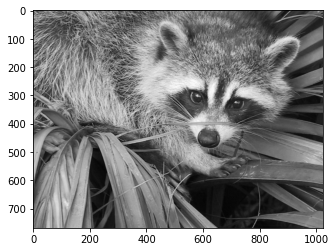

In [132]:
# if __name__ == "__main__":
    # Parse argument (image)
#     argument_parser = argparse.ArgumentParser()
#     argument_parser.add_argument('-i', '--image',
#                                  help='path to image file',
#                                  default='.//raccoon.jpg')
#     arguments = vars(argument_parser.parse_args())
    # Read image
#     image = cv2.imread(arguments['image'], 0).astype(int)  # load pix-mapped image

# +++
# to show image in the same window as a code
%matplotlib inline

image = cv2.imread('.//raccoon.jpg', 0).astype(int)  # manual load pix-mapped image
                                        # instead of arguments parsing for image load 
plt.imshow(image, cmap='gray') # show the image below in gray
plt.show()  
#+++


In [133]:
from pprint import pprint # +++

with open("frame_of_patterns_.csv", "a") as csvFile:  # +++
    write = csv.writer(csvFile, delimiter=",")        # +++
    fieldnames = ("L=", "I=", "D=", "M=", "x0=")      # +++
    write.writerow(fieldnames)                        # +++
    
assert image is not None, "No image in the path"
image = image.astype(int)

start_time = time()
# Main
frame_of_patterns_ = cross_comp(image)  # returns Pm__
pprint(frame_of_patterns_) # to show the output results in the convinient way +++ 

fline_PPs = 0
if fline_PPs:  # debug line_PPs_draft
    from line_PPs_draft import *
    frame_PP_ = []

    for y, P_ in enumerate(frame_of_patterns_):
        PPm_, PPd_ = search(P_)
        frame_PP_.append([PPm_, PPd_])

end_time = time() - start_time

[[CP(L=2, I=196, D=22, M=-22.5, x0=0),
  CP(L=34, I=3058, D=-50, M=607, x0=2),
  CP(L=1, I=76, D=17, M=-4, x0=36),
  CP(L=15, I=1813, D=74, M=212, x0=37),
  CP(L=1, I=169, D=19, M=-10, x0=52),
  CP(L=3, I=574, D=20, M=26, x0=53),
  CP(L=4, I=574, D=-72, M=-16, x0=56),
  CP(L=22, I=2201, D=-29, M=352, x0=60),
  CP(L=5, I=295, D=10, M=-101, x0=82),
  CP(L=16, I=1385, D=-23, M=209, x0=87),
  CP(L=1, I=94, D=19, M=-12, x0=103),
  CP(L=8, I=984, D=48, M=143, x0=104),
  CP(L=1, I=122, D=-20, M=-2, x0=112),
  CP(L=4, I=375, D=-44, M=32, x0=113),
  CP(L=3, I=359, D=69, M=-45, x0=117),
  CP(L=2, I=308, D=5, M=30, x0=120),
  CP(L=2, I=257, D=-34, M=-12, x0=122),
  CP(L=4, I=393, D=-18, M=55, x0=124),
  CP(L=1, I=126, D=26, M=-7, x0=128),
  CP(L=14, I=1858, D=14, M=263, x0=129),
  CP(L=1, I=132, D=-8, M=-2, x0=143),
  CP(L=8, I=883, D=-21, M=151, x0=144),
  CP(L=2, I=263, D=30, M=-1, x0=152),
  CP(L=4, I=557, D=-10, M=38, x0=154),
  CP(L=1, I=149, D=18, M=-4, x0=158),
  CP(L=9, I=1578, D=46, M=13

  CP(L=1, I=120, D=-16, M=-3, x0=617),
  CP(L=22, I=2507, D=-20, M=430, x0=618),
  CP(L=1, I=77, D=-23, M=-1, x0=640),
  CP(L=35, I=4050, D=13, M=607, x0=641),
  CP(L=1, I=107, D=17, M=0, x0=676),
  CP(L=31, I=3160, D=-5, M=647, x0=677),
  CP(L=1, I=116, D=14, M=0, x0=708),
  CP(L=162, I=12938, D=8, M=3731, x0=709),
  CP(L=3, I=255, D=-64, M=-45, x0=871),
  CP(L=24, I=775, D=-33, M=502, x0=874),
  CP(L=4, I=355, D=118, M=-117, x0=898),
  CP(L=1, I=154, D=9, M=15, x0=902),
  CP(L=3, I=319, D=-87, M=-107, x0=903),
  CP(L=102, I=7137, D=70, M=2533, x0=906),
  CP(L=2, I=231, D=-31, M=-4, x0=1008),
  CP(L=14, I=1569, D=-8, M=247.0, x0=1010)],
 [CP(L=7, I=708, D=-39, M=76.0, x0=0),
  CP(L=3, I=402, D=75, M=-60, x0=7),
  CP(L=6, I=937, D=-26, M=66, x0=10),
  CP(L=1, I=113, D=-23, M=-4, x0=16),
  CP(L=3, I=287, D=-19, M=35, x0=17),
  CP(L=2, I=240, D=36, M=-6, x0=20),
  CP(L=15, I=2040, D=16, M=175, x0=22),
  CP(L=2, I=228, D=-43, M=-16, x0=37),
  CP(L=1, I=92, D=-11, M=1, x0=39),
  CP(L=4, I=

  CP(L=10, I=1546, D=11, M=119, x0=151),
  CP(L=1, I=164, D=21, M=-6, x0=161),
  CP(L=20, I=3219, D=-8, M=400, x0=162),
  CP(L=1, I=175, D=19, M=-5, x0=182),
  CP(L=2, I=380, D=14, M=14, x0=183),
  CP(L=3, I=356, D=-113, M=-122, x0=185),
  CP(L=4, I=277, D=-10, M=65, x0=188),
  CP(L=4, I=392, D=70, M=-50, x0=192),
  CP(L=6, I=917, D=28, M=120, x0=196),
  CP(L=1, I=177, D=13, M=0, x0=202),
  CP(L=6, I=1081, D=-22, M=51, x0=203),
  CP(L=6, I=837, D=37, M=-121, x0=209),
  CP(L=1, I=187, D=-5, M=16, x0=215),
  CP(L=3, I=412, D=-92, M=-108, x0=216),
  CP(L=4, I=263, D=-36, M=67, x0=219),
  CP(L=5, I=557, D=61, M=-108, x0=223),
  CP(L=12, I=1512, D=8, M=92, x0=228),
  CP(L=1, I=112, D=-16, M=-1, x0=240),
  CP(L=2, I=258, D=19, M=27, x0=241),
  CP(L=2, I=307, D=35, M=-6, x0=243),
  CP(L=6, I=923, D=-37, M=65, x0=245),
  CP(L=2, I=312, D=39, M=-9, x0=251),
  CP(L=1, I=174, D=6, M=6, x0=253),
  CP(L=2, I=290, D=-40, M=-16, x0=254),
  CP(L=21, I=2771, D=-8, M=343, x0=256),
  CP(L=7, I=846, D=62,

  CP(L=1, I=111, D=-19, M=-8, x0=572),
  CP(L=2, I=188, D=-15, M=16, x0=573),
  CP(L=4, I=504, D=7, M=-97, x0=575),
  CP(L=1, I=95, D=-8, M=4, x0=579),
  CP(L=2, I=251, D=43, M=-22, x0=580),
  CP(L=7, I=1141, D=40, M=112, x0=582),
  CP(L=1, I=162, D=-16, M=-2, x0=589),
  CP(L=10, I=1276, D=-66, M=152, x0=590),
  CP(L=2, I=202, D=18, M=-24, x0=600),
  CP(L=26, I=3825, D=36, M=398, x0=602),
  CP(L=2, I=261, D=-33, M=-18, x0=628),
  CP(L=21, I=2262, D=-15, M=402, x0=630),
  CP(L=1, I=122, D=20, M=-8, x0=651),
  CP(L=10, I=1212, D=-7, M=133, x0=652),
  CP(L=1, I=96, D=-19, M=-3, x0=662),
  CP(L=218, I=15628, D=-58, M=5153, x0=663),
  CP(L=4, I=279, D=87, M=-121, x0=881),
  CP(L=2, I=306, D=28, M=7, x0=885),
  CP(L=3, I=237, D=-112, M=-129, x0=887),
  CP(L=10, I=377, D=27, M=174, x0=890),
  CP(L=3, I=297, D=51, M=-15, x0=900),
  CP(L=19, I=2889, D=13, M=348, x0=903),
  CP(L=1, I=117, D=-15, M=0, x0=922),
  CP(L=78, I=5752, D=-24, M=1729, x0=923),
  CP(L=2, I=125, D=-43, M=-26, x0=1001),
  C

  CP(L=3, I=403, D=69, M=-32, x0=399),
  CP(L=1, I=156, D=-4, M=2, x0=402),
  CP(L=1, I=132, D=-24, M=-3, x0=403),
  CP(L=7, I=741, D=-37, M=103, x0=404),
  CP(L=1, I=117, D=22, M=-16, x0=411),
  CP(L=2, I=287, D=29, M=10, x0=412),
  CP(L=1, I=130, D=-16, M=-4, x0=414),
  CP(L=4, I=409, D=-30, M=40, x0=415),
  CP(L=2, I=272, D=50, M=-34, x0=419),
  CP(L=3, I=504, D=18, M=52, x0=421),
  CP(L=2, I=293, D=-33, M=-15, x0=424),
  CP(L=1, I=116, D=-19, M=3, x0=426),
  CP(L=5, I=693, D=1, M=-34, x0=427),
  CP(L=4, I=446, D=-2, M=50, x0=432),
  CP(L=1, I=95, D=-20, M=-8, x0=436),
  CP(L=9, I=813, D=-17, M=109, x0=437),
  CP(L=5, I=605, D=29, M=-57, x0=446),
  CP(L=1, I=97, D=-10, M=4, x0=451),
  CP(L=2, I=252, D=42, M=-22, x0=452),
  CP(L=12, I=1944, D=-3, M=194, x0=454),
  CP(L=2, I=304, D=30, M=-11, x0=466),
  CP(L=16, I=2483, D=-19, M=239, x0=468),
  CP(L=1, I=135, D=-12, M=-5, x0=484),
  CP(L=34, I=4776, D=-25, M=490, x0=485),
  CP(L=4, I=390, D=3, M=-25, x0=519),
  CP(L=21, I=2660, D=31, 

  CP(L=7, I=1170, D=27, M=120, x0=234),
  CP(L=4, I=469, D=-80, M=-33, x0=241),
  CP(L=1, I=75, D=-12, M=8, x0=245),
  CP(L=1, I=85, D=10, M=0, x0=246),
  CP(L=5, I=524, D=28, M=74, x0=247),
  CP(L=1, I=101, D=-12, M=-1, x0=252),
  CP(L=1, I=82, D=-19, M=1, x0=253),
  CP(L=5, I=483, D=-30, M=-103, x0=254),
  CP(L=2, I=72, D=-13, M=10, x0=259),
  CP(L=3, I=238, D=59, M=-27, x0=261),
  CP(L=16, I=1609, D=-14, M=250, x0=264),
  CP(L=1, I=104, D=20, M=0, x0=280),
  CP(L=8, I=1093, D=30, M=105, x0=281),
  CP(L=2, I=215, D=-36, M=-9, x0=289),
  CP(L=13, I=944, D=-31, M=158, x0=291),
  CP(L=2, I=213, D=51, M=-28, x0=304),
  CP(L=2, I=259, D=9, M=20, x0=306),
  CP(L=1, I=111, D=-16, M=-2, x0=308),
  CP(L=2, I=194, D=-12, M=15, x0=309),
  CP(L=4, I=436, D=-16, M=-35, x0=311),
  CP(L=2, I=201, D=23, M=11, x0=315),
  CP(L=2, I=156, D=-41, M=-23, x0=317),
  CP(L=3, I=171, D=-3, M=31, x0=319),
  CP(L=1, I=79, D=17, M=-1, x0=322),
  CP(L=4, I=334, D=-7, M=55, x0=323),
  CP(L=12, I=1115, D=23, M=-272

  CP(L=1, I=116, D=-12, M=0, x0=228),
  CP(L=9, I=923, D=-26, M=98, x0=229),
  CP(L=3, I=404, D=76, M=-49, x0=238),
  CP(L=16, I=2705, D=16, M=277, x0=241),
  CP(L=2, I=298, D=-46, M=-22, x0=257),
  CP(L=13, I=1615, D=-56, M=143, x0=259),
  CP(L=1, I=105, D=25, M=-1, x0=272),
  CP(L=1, I=99, D=-6, M=11, x0=273),
  CP(L=2, I=154, D=-31, M=-6, x0=274),
  CP(L=5, I=228, D=-26, M=78, x0=276),
  CP(L=1, I=59, D=17, M=0, x0=281),
  CP(L=4, I=345, D=43, M=35, x0=282),
  CP(L=2, I=158, D=-34, M=-16, x0=286),
  CP(L=2, I=104, D=-12, M=8, x0=288),
  CP(L=4, I=426, D=85, M=-49, x0=290),
  CP(L=1, I=156, D=15, M=9, x0=294),
  CP(L=2, I=298, D=-20, M=-4, x0=295),
  CP(L=1, I=130, D=-6, M=7, x0=297),
  CP(L=2, I=198, D=-45, M=-31, x0=298),
  CP(L=1, I=67, D=-18, M=1, x0=300),
  CP(L=7, I=728, D=57, M=-155, x0=301),
  CP(L=2, I=235, D=-11, M=25, x0=308),
  CP(L=2, I=169, D=-42, M=-15, x0=310),
  CP(L=3, I=238, D=17, M=18, x0=312),
  CP(L=6, I=569, D=20, M=-83, x0=315),
  CP(L=3, I=319, D=-3, M=52, x0

  CP(L=1, I=71, D=8, M=-3, x0=151),
  CP(L=12, I=1173, D=55, M=183, x0=152),
  CP(L=2, I=191, D=-45, M=-28, x0=164),
  CP(L=4, I=269, D=-16, M=81, x0=166),
  CP(L=2, I=84, D=-33, M=-5, x0=170),
  CP(L=1, I=20, D=-12, M=8, x0=172),
  CP(L=4, I=297, D=100, M=-90, x0=173),
  CP(L=2, I=284, D=24, M=13, x0=177),
  CP(L=3, I=289, D=-77, M=-64, x0=179),
  CP(L=1, I=48, D=-19, M=10, x0=182),
  CP(L=2, I=133, D=38, M=-30, x0=183),
  CP(L=1, I=97, D=11, M=7, x0=185),
  CP(L=5, I=448, D=20, M=-99, x0=186),
  CP(L=5, I=635, D=-1, M=51, x0=191),
  CP(L=1, I=134, D=18, M=0, x0=196),
  CP(L=1, I=146, D=12, M=2, x0=197),
  CP(L=3, I=325, D=-57, M=-24, x0=198),
  CP(L=1, I=73, D=-16, M=1, x0=201),
  CP(L=3, I=362, D=78, M=-60, x0=202),
  CP(L=2, I=313, D=4, M=40, x0=205),
  CP(L=3, I=370, D=-56, M=-34, x0=207),
  CP(L=9, I=728, D=-28, M=142, x0=210),
  CP(L=3, I=319, D=65, M=-41, x0=219),
  CP(L=9, I=1106, D=-24, M=91, x0=222),
  CP(L=2, I=240, D=23, M=-21, x0=231),
  CP(L=1, I=149, D=14, M=5, x0=233),

 [CP(L=2, I=343, D=31, M=-30.0, x0=0),
  CP(L=17, I=2186, D=-67, M=245, x0=2),
  CP(L=3, I=256, D=-56, M=-22, x0=19),
  CP(L=5, I=272, D=3, M=67, x0=22),
  CP(L=1, I=84, D=17, M=-3, x0=27),
  CP(L=6, I=669, D=23, M=86, x0=28),
  CP(L=1, I=91, D=-16, M=-3, x0=34),
  CP(L=13, I=1034, D=-26, M=240, x0=35),
  CP(L=4, I=443, D=81, M=-43, x0=48),
  CP(L=19, I=2377, D=-6, M=341, x0=52),
  CP(L=4, I=293, D=-108, M=-88, x0=71),
  CP(L=4, I=219, D=35, M=43, x0=75),
  CP(L=1, I=83, D=16, M=-3, x0=79),
  CP(L=12, I=1087, D=10, M=164, x0=80),
  CP(L=1, I=76, D=-17, M=-6, x0=92),
  CP(L=2, I=118, D=-15, M=11, x0=93),
  CP(L=1, I=83, D=22, M=-5, x0=95),
  CP(L=7, I=664, D=12, M=121, x0=96),
  CP(L=1, I=81, D=-14, M=-4, x0=103),
  CP(L=16, I=936, D=-27, M=371, x0=104),
  CP(L=1, I=73, D=19, M=0, x0=120),
  CP(L=2, I=168, D=11, M=44, x0=121),
  CP(L=5, I=377, D=36, M=-97, x0=123),
  CP(L=2, I=256, D=4, M=12, x0=128),
  CP(L=2, I=182, D=-46, M=-27, x0=130),
  CP(L=12, I=834, D=11, M=223, x0=132),
  CP(L

  CP(L=2, I=179, D=-37, M=-10, x0=313),
  CP(L=11, I=934, D=34, M=161, x0=315),
  CP(L=2, I=176, D=-37, M=-20, x0=326),
  CP(L=13, I=883, D=-17, M=171, x0=328),
  CP(L=2, I=188, D=46, M=-20, x0=341),
  CP(L=4, I=470, D=9, M=74, x0=343),
  CP(L=1, I=98, D=-16, M=-2, x0=347),
  CP(L=2, I=166, D=-14, M=18, x0=348),
  CP(L=1, I=106, D=22, M=-13, x0=350),
  CP(L=2, I=253, D=20, M=9, x0=351),
  CP(L=2, I=162, D=-62, M=-56, x0=353),
  CP(L=2, I=82, D=-26, M=18, x0=355),
  CP(L=4, I=348, D=96, M=-79, x0=357),
  CP(L=2, I=310, D=25, M=19, x0=361),
  CP(L=2, I=279, D=-31, M=-20, x0=363),
  CP(L=2, I=201, D=-29, M=10, x0=365),
  CP(L=2, I=268, D=52, M=-32, x0=367),
  CP(L=32, I=5551, D=17, M=479, x0=369),
  CP(L=1, I=185, D=17, M=-4, x0=401),
  CP(L=21, I=4100, D=-7, M=389, x0=402),
  CP(L=1, I=194, D=16, M=0, x0=423),
  CP(L=24, I=4274, D=0, M=371, x0=424),
  CP(L=2, I=330, D=-39, M=-18, x0=448),
  CP(L=72, I=9724, D=45, M=1478, x0=450),
  CP(L=2, I=347, D=-38, M=-9, x0=522),
  CP(L=3, I=486, D=

  CP(L=2, I=200, D=-44, M=-23, x0=663),
  CP(L=74, I=6790, D=4, M=1592, x0=665),
  CP(L=1, I=109, D=19, M=-3, x0=739),
  CP(L=26, I=2457, D=-16, M=365, x0=740),
  CP(L=1, I=106, D=13, M=0, x0=766),
  CP(L=2, I=248, D=19, M=16, x0=767),
  CP(L=2, I=180, D=-47, M=-18, x0=769),
  CP(L=11, I=1006, D=38, M=188, x0=771),
  CP(L=2, I=187, D=-32, M=-7, x0=782),
  CP(L=6, I=746, D=57, M=59, x0=784),
  CP(L=3, I=272, D=-76, M=-46, x0=790),
  CP(L=6, I=582, D=53, M=78, x0=793),
  CP(L=2, I=198, D=-35, M=-20, x0=799),
  CP(L=138, I=10178, D=-9, M=3279, x0=801),
  CP(L=1, I=62, D=-12, M=0, x0=939),
  CP(L=11, I=610, D=6, M=168, x0=940),
  CP(L=1, I=60, D=-8, M=-1, x0=951),
  CP(L=72, I=6639, D=68, M=1819.0, x0=952)],
 [CP(L=2, I=271, D=-23, M=-24.0, x0=0),
  CP(L=3, I=288, D=-37, M=34, x0=2),
  CP(L=4, I=550, D=96, M=-81, x0=5),
  CP(L=1, I=173, D=-10, M=3, x0=9),
  CP(L=10, I=1272, D=-93, M=-386, x0=10),
  CP(L=7, I=554, D=-13, M=72, x0=20),
  CP(L=3, I=380, D=106, M=-112, x0=27),
  CP(L=1, I=176,

  CP(L=2, I=196, D=-22, M=22, x0=37),
  CP(L=5, I=696, D=95, M=-117, x0=39),
  CP(L=1, I=206, D=13, M=6, x0=44),
  CP(L=8, I=923, D=-35, M=-343, x0=45),
  CP(L=1, I=183, D=12, M=6, x0=53),
  CP(L=6, I=707, D=-122, M=-60, x0=54),
  CP(L=1, I=53, D=-8, M=2, x0=60),
  CP(L=3, I=292, D=65, M=-34, x0=61),
  CP(L=1, I=104, D=-14, M=1, x0=64),
  CP(L=2, I=158, D=-35, M=-8, x0=65),
  CP(L=2, I=114, D=-11, M=30, x0=67),
  CP(L=3, I=261, D=43, M=-7, x0=69),
  CP(L=2, I=250, D=24, M=26, x0=72),
  CP(L=2, I=210, D=-30, M=-1, x0=74),
  CP(L=15, I=1317, D=31, M=259, x0=76),
  CP(L=2, I=179, D=-53, M=-46, x0=91),
  CP(L=26, I=1958, D=-4, M=513, x0=93),
  CP(L=2, I=191, D=38, M=-15, x0=119),
  CP(L=3, I=387, D=25, M=29, x0=121),
  CP(L=2, I=210, D=-37, M=-9, x0=124),
  CP(L=3, I=230, D=-27, M=35, x0=126),
  CP(L=2, I=179, D=30, M=-1, x0=129),
  CP(L=5, I=656, D=53, M=57, x0=131),
  CP(L=5, I=476, D=-77, M=-82, x0=136),
  CP(L=9, I=845, D=43, M=112, x0=141),
  CP(L=1, I=132, D=15, M=-3, x0=150),
  CP(L

  CP(L=1, I=150, D=-17, M=-9, x0=236),
  CP(L=8, I=1114, D=12, M=107, x0=237),
  CP(L=3, I=358, D=-74, M=-60, x0=245),
  CP(L=4, I=353, D=9, M=39, x0=248),
  CP(L=1, I=121, D=24, M=-15, x0=252),
  CP(L=6, I=807, D=5, M=101, x0=253),
  CP(L=2, I=301, D=35, M=-8, x0=259),
  CP(L=11, I=1666, D=-16, M=179, x0=261),
  CP(L=4, I=377, D=-59, M=-65, x0=272),
  CP(L=2, I=211, D=21, M=24, x0=276),
  CP(L=1, I=119, D=12, M=-2, x0=278),
  CP(L=6, I=802, D=1, M=95, x0=279),
  CP(L=3, I=248, D=-69, M=-58, x0=285),
  CP(L=3, I=110, D=-9, M=39, x0=288),
  CP(L=4, I=482, D=137, M=-137, x0=291),
  CP(L=6, I=948, D=-34, M=91, x0=295),
  CP(L=4, I=361, D=-93, M=-55, x0=301),
  CP(L=6, I=367, D=39, M=60, x0=305),
  CP(L=2, I=227, D=36, M=-14, x0=311),
  CP(L=4, I=565, D=13, M=73, x0=313),
  CP(L=2, I=326, D=34, M=-12, x0=317),
  CP(L=12, I=2071, D=6, M=194, x0=319),
  CP(L=2, I=303, D=-47, M=-37, x0=331),
  CP(L=6, I=795, D=5, M=112, x0=333),
  CP(L=6, I=387, D=-75, M=-137, x0=339),
  CP(L=2, I=163, D=19, 

 [CP(L=2, I=310, D=2, M=33.5, x0=0),
  CP(L=2, I=256, D=-42, M=-26, x0=2),
  CP(L=1, I=98, D=-16, M=1, x0=4),
  CP(L=3, I=412, D=63, M=-33, x0=5),
  CP(L=5, I=848, D=2, M=99, x0=8),
  CP(L=3, I=353, D=-67, M=-42, x0=13),
  CP(L=2, I=236, D=25, M=12, x0=16),
  CP(L=2, I=299, D=40, M=-21, x0=18),
  CP(L=6, I=1124, D=39, M=113, x0=20),
  CP(L=3, I=488, D=-74, M=-72, x0=26),
  CP(L=6, I=748, D=2, M=52, x0=29),
  CP(L=1, I=111, D=-17, M=0, x0=35),
  CP(L=1, I=98, D=-13, M=7, x0=36),
  CP(L=6, I=789, D=-11, M=-134, x0=37),
  CP(L=5, I=363, D=-1, M=58, x0=43),
  CP(L=6, I=831, D=43, M=-57, x0=48),
  CP(L=1, I=118, D=-11, M=12, x0=54),
  CP(L=1, I=125, D=7, M=-3, x0=55),
  CP(L=2, I=305, D=29, M=13, x0=56),
  CP(L=2, I=256, D=-37, M=-13, x0=58),
  CP(L=6, I=508, D=-47, M=70, x0=60),
  CP(L=6, I=714, D=32, M=-74, x0=66),
  CP(L=4, I=318, D=-24, M=72, x0=72),
  CP(L=2, I=233, D=57, M=-47, x0=76),
  CP(L=1, I=148, D=13, M=1, x0=78),
  CP(L=2, I=235, D=-45, M=-29, x0=79),
  CP(L=13, I=1156, D=9, M

  CP(L=4, I=501, D=8, M=25, x0=613),
  CP(L=1, I=127, D=-16, M=0, x0=617),
  CP(L=4, I=480, D=10, M=31, x0=618),
  CP(L=2, I=221, D=-42, M=-30, x0=622),
  CP(L=2, I=151, D=-22, M=10, x0=624),
  CP(L=1, I=96, D=23, M=-11, x0=626),
  CP(L=3, I=355, D=26, M=39, x0=627),
  CP(L=2, I=317, D=56, M=-41, x0=630),
  CP(L=1, I=184, D=6, M=5, x0=632),
  CP(L=5, I=677, D=-28, M=-99, x0=633),
  CP(L=46, I=5244, D=-37, M=723, x0=638),
  CP(L=2, I=300, D=43, M=-15, x0=684),
  CP(L=11, I=1545, D=-57, M=147, x0=686),
  CP(L=1, I=126, D=21, M=-6, x0=697),
  CP(L=9, I=1270, D=11, M=132, x0=698),
  CP(L=1, I=118, D=-19, M=-6, x0=707),
  CP(L=6, I=652, D=0, M=63, x0=708),
  CP(L=1, I=100, D=-18, M=-2, x0=714),
  CP(L=1, I=86, D=-14, M=5, x0=715),
  CP(L=2, I=220, D=37, M=-12, x0=716),
  CP(L=1, I=132, D=9, M=13, x0=718),
  CP(L=2, I=222, D=-34, M=-4, x0=719),
  CP(L=35, I=3416, D=-16, M=683, x0=721),
  CP(L=2, I=250, D=59, M=-34, x0=756),
  CP(L=1, I=144, D=3, M=11, x0=758),
  CP(L=3, I=339, D=-29, M=-43, 

  CP(L=2, I=345, D=13, M=30, x0=165),
  CP(L=3, I=355, D=-84, M=-75, x0=167),
  CP(L=17, I=1979, D=58, M=238, x0=170),
  CP(L=3, I=328, D=-60, M=-35, x0=187),
  CP(L=10, I=563, D=-32, M=210, x0=190),
  CP(L=6, I=424, D=98, M=-170, x0=200),
  CP(L=4, I=650, D=5, M=66, x0=206),
  CP(L=6, I=674, D=-23, M=-125, x0=210),
  CP(L=7, I=932, D=-16, M=112, x0=216),
  CP(L=2, I=180, D=-43, M=-19, x0=223),
  CP(L=3, I=234, D=9, M=36, x0=225),
  CP(L=1, I=97, D=12, M=0, x0=228),
  CP(L=7, I=998, D=57, M=74, x0=229),
  CP(L=2, I=243, D=-45, M=-27, x0=236),
  CP(L=19, I=2395, D=57, M=228, x0=238),
  CP(L=3, I=367, D=-71, M=-52, x0=257),
  CP(L=2, I=156, D=-17, M=24, x0=260),
  CP(L=4, I=397, D=5, M=-23, x0=262),
  CP(L=2, I=137, D=-13, M=15, x0=266),
  CP(L=3, I=359, D=74, M=-45, x0=268),
  CP(L=3, I=490, D=22, M=27, x0=271),
  CP(L=5, I=560, D=-99, M=-54, x0=274),
  CP(L=2, I=95, D=-20, M=26, x0=279),
  CP(L=2, I=140, D=33, M=-8, x0=281),
  CP(L=2, I=188, D=13, M=24, x0=283),
  CP(L=1, I=76, D=-17, 

  CP(L=2, I=323, D=26, M=6, x0=588),
  CP(L=2, I=260, D=-49, M=-35, x0=590),
  CP(L=2, I=201, D=-13, M=18, x0=592),
  CP(L=1, I=117, D=14, M=0, x0=594),
  CP(L=11, I=1505, D=10, M=173, x0=595),
  CP(L=2, I=299, D=40, M=-35, x0=606),
  CP(L=5, I=932, D=18, M=89, x0=608),
  CP(L=2, I=331, D=-30, M=-17, x0=613),
  CP(L=2, I=259, D=-25, M=6, x0=615),
  CP(L=1, I=156, D=26, M=-4, x0=617),
  CP(L=6, I=945, D=9, M=49, x0=618),
  CP(L=1, I=152, D=-13, M=-1, x0=624),
  CP(L=5, I=793, D=-2, M=41, x0=625),
  CP(L=2, I=375, D=52, M=-26, x0=630),
  CP(L=5, I=1002, D=-7, M=96, x0=632),
  CP(L=2, I=339, D=-38, M=-19, x0=637),
  CP(L=5, I=742, D=-5, M=67, x0=639),
  CP(L=4, I=679, D=-8, M=-26, x0=644),
  CP(L=1, I=151, D=7, M=2, x0=648),
  CP(L=1, I=172, D=21, M=-9, x0=649),
  CP(L=2, I=378, D=16, M=23, x0=650),
  CP(L=3, I=457, D=-57, M=-28, x0=652),
  CP(L=2, I=231, D=-12, M=22, x0=655),
  CP(L=2, I=278, D=35, M=-20, x0=657),
  CP(L=1, I=169, D=15, M=1, x0=659),
  CP(L=3, I=381, D=-68, M=-41, x0=660

  CP(L=1, I=115, D=-17, M=-14, x0=239),
  CP(L=8, I=783, D=-3, M=141, x0=240),
  CP(L=1, I=92, D=-20, M=-3, x0=248),
  CP(L=4, I=253, D=-38, M=40, x0=249),
  CP(L=7, I=761, D=10, M=-159, x0=253),
  CP(L=5, I=414, D=15, M=57, x0=260),
  CP(L=2, I=202, D=31, M=-3, x0=265),
  CP(L=3, I=382, D=17, M=37, x0=267),
  CP(L=2, I=203, D=-34, M=-11, x0=270),
  CP(L=4, I=239, D=-52, M=25, x0=272),
  CP(L=2, I=133, D=40, M=-24, x0=276),
  CP(L=1, I=96, D=15, M=11, x0=278),
  CP(L=2, I=156, D=-32, M=-15, x0=279),
  CP(L=1, I=49, D=-15, M=9, x0=281),
  CP(L=9, I=1122, D=120, M=-164, x0=282),
  CP(L=8, I=1244, D=-31, M=150, x0=291),
  CP(L=6, I=452, D=-53, M=-139, x0=299),
  CP(L=4, I=306, D=0, M=54, x0=305),
  CP(L=8, I=753, D=32, M=-181, x0=309),
  CP(L=2, I=196, D=-26, M=8, x0=317),
  CP(L=4, I=224, D=-22, M=-70, x0=319),
  CP(L=8, I=674, D=28, M=109, x0=323),
  CP(L=5, I=386, D=6, M=-39, x0=331),
  CP(L=29, I=4518, D=93, M=478, x0=336),
  CP(L=2, I=344, D=-36, M=-22, x0=365),
  CP(L=2, I=276, D=-2

 [CP(L=2, I=341, D=-5, M=26.0, x0=0),
  CP(L=3, I=354, D=-87, M=-80, x0=2),
  CP(L=12, I=845, D=-19, M=227, x0=5),
  CP(L=1, I=83, D=21, M=-14, x0=17),
  CP(L=6, I=618, D=33, M=46, x0=18),
  CP(L=7, I=688, D=54, M=-205, x0=24),
  CP(L=1, I=180, D=10, M=4, x0=31),
  CP(L=7, I=783, D=-31, M=-183, x0=32),
  CP(L=4, I=592, D=-15, M=49, x0=39),
  CP(L=7, I=821, D=40, M=-109, x0=43),
  CP(L=6, I=1131, D=25, M=102, x0=50),
  CP(L=3, I=416, D=-108, M=-128, x0=56),
  CP(L=3, I=249, D=1, M=21, x0=59),
  CP(L=2, I=238, D=38, M=-8, x0=62),
  CP(L=1, I=138, D=8, M=19, x0=64),
  CP(L=7, I=660, D=-1, M=-151, x0=65),
  CP(L=2, I=292, D=4, M=9, x0=72),
  CP(L=1, I=124, D=-17, M=-3, x0=74),
  CP(L=7, I=784, D=-20, M=109, x0=75),
  CP(L=3, I=418, D=65, M=-49, x0=82),
  CP(L=2, I=360, D=8, M=18, x0=85),
  CP(L=4, I=660, D=15, M=-49, x0=87),
  CP(L=1, I=203, D=11, M=11, x0=91),
  CP(L=3, I=504, D=-64, M=-50, x0=92),
  CP(L=2, I=243, D=-15, M=6, x0=95),
  CP(L=1, I=100, D=-24, M=-9, x0=97),
  CP(L=8, I=909,

  CP(L=2, I=194, D=-21, M=10, x0=746),
  CP(L=3, I=424, D=48, M=-34, x0=748),
  CP(L=5, I=577, D=-36, M=68, x0=751),
  CP(L=1, I=128, D=19, M=-5, x0=756),
  CP(L=1, I=144, D=16, M=2, x0=757),
  CP(L=1, I=132, D=-12, M=-7, x0=758),
  CP(L=4, I=376, D=-51, M=17, x0=759),
  CP(L=2, I=262, D=74, M=-72, x0=763),
  CP(L=1, I=165, D=10, M=15, x0=765),
  CP(L=11, I=1300, D=-3, M=-239, x0=766),
  CP(L=3, I=441, D=-16, M=55, x0=777),
  CP(L=1, I=135, D=-11, M=0, x0=780),
  CP(L=2, I=227, D=-24, M=23, x0=781),
  CP(L=2, I=264, D=34, M=-4, x0=783),
  CP(L=15, I=1803, D=-28, M=255, x0=785),
  CP(L=2, I=167, D=-48, M=-32, x0=800),
  CP(L=1, I=54, D=-15, M=2, x0=802),
  CP(L=3, I=300, D=80, M=-74, x0=803),
  CP(L=3, I=434, D=3, M=34, x0=806),
  CP(L=2, I=227, D=-36, M=-17, x0=809),
  CP(L=2, I=178, D=-8, M=11, x0=811),
  CP(L=2, I=237, D=34, M=-6, x0=813),
  CP(L=1, I=142, D=15, M=11, x0=815),
  CP(L=6, I=801, D=51, M=-131, x0=816),
  CP(L=1, I=192, D=-1, M=15, x0=822),
  CP(L=1, I=178, D=-14, M=-3, 

  CP(L=1, I=117, D=23, M=-8, x0=605),
  CP(L=3, I=397, D=12, M=35, x0=606),
  CP(L=2, I=199, D=-41, M=-14, x0=609),
  CP(L=1, I=78, D=-10, M=10, x0=611),
  CP(L=2, I=196, D=30, M=-2, x0=612),
  CP(L=13, I=1472, D=-6, M=233, x0=614),
  CP(L=2, I=255, D=38, M=-11, x0=627),
  CP(L=1, I=148, D=8, M=6, x0=629),
  CP(L=5, I=658, D=23, M=-107, x0=630),
  CP(L=15, I=2122, D=-55, M=248, x0=635),
  CP(L=7, I=896, D=44, M=-149, x0=650),
  CP(L=1, I=158, D=-2, M=14, x0=657),
  CP(L=1, I=172, D=14, M=-7, x0=658),
  CP(L=16, I=2798, D=20, M=231, x0=659),
  CP(L=4, I=542, D=-107, M=-87, x0=675),
  CP(L=11, I=1190, D=11, M=136, x0=679),
  CP(L=4, I=469, D=-2, M=-53, x0=690),
  CP(L=2, I=149, D=-17, M=9, x0=694),
  CP(L=3, I=333, D=53, M=-19, x0=696),
  CP(L=6, I=871, D=13, M=79, x0=699),
  CP(L=1, I=122, D=-21, M=-4, x0=705),
  CP(L=10, I=1261, D=-7, M=148, x0=706),
  CP(L=2, I=268, D=31, M=-4, x0=716),
  CP(L=2, I=302, D=1, M=25, x0=718),
  CP(L=2, I=303, D=19, M=-27, x0=720),
  CP(L=2, I=371, D=20, 

  CP(L=4, I=504, D=-6, M=12, x0=91),
  CP(L=2, I=294, D=56, M=-44, x0=95),
  CP(L=3, I=541, D=15, M=45, x0=97),
  CP(L=3, I=427, D=-67, M=-56, x0=100),
  CP(L=4, I=374, D=-15, M=55, x0=103),
  CP(L=2, I=270, D=52, M=-36, x0=107),
  CP(L=4, I=678, D=27, M=65, x0=109),
  CP(L=1, I=165, D=-13, M=-1, x0=113),
  CP(L=7, I=1022, D=-39, M=43, x0=114),
  CP(L=1, I=145, D=19, M=-1, x0=121),
  CP(L=2, I=313, D=11, M=33, x0=122),
  CP(L=2, I=262, D=-37, M=-16, x0=124),
  CP(L=2, I=211, D=-12, M=24, x0=126),
  CP(L=3, I=422, D=56, M=-22, x0=128),
  CP(L=2, I=350, D=9, M=16, x0=131),
  CP(L=3, I=366, D=-84, M=-68, x0=133),
  CP(L=8, I=908, D=49, M=76, x0=136),
  CP(L=3, I=413, D=27, M=-49, x0=144),
  CP(L=3, I=560, D=21, M=39, x0=147),
  CP(L=2, I=320, D=-35, M=-12, x0=150),
  CP(L=7, I=912, D=-28, M=130, x0=152),
  CP(L=1, I=143, D=21, M=-11, x0=159),
  CP(L=2, I=323, D=17, M=19, x0=160),
  CP(L=3, I=355, D=-67, M=-36, x0=162),
  CP(L=13, I=1537, D=50, M=186, x0=165),
  CP(L=2, I=235, D=-36, M=-13

  CP(L=2, I=291, D=-48, M=-22, x0=747),
  CP(L=4, I=569, D=21, M=32, x0=749),
  CP(L=8, I=832, D=-80, M=-123, x0=753),
  CP(L=1, I=73, D=0, M=9, x0=761),
  CP(L=4, I=431, D=19, M=-40, x0=762),
  CP(L=11, I=1094, D=31, M=181, x0=766),
  CP(L=4, I=270, D=-56, M=-65, x0=777),
  CP(L=11, I=1040, D=10, M=172, x0=781),
  CP(L=2, I=201, D=34, M=-11, x0=792),
  CP(L=2, I=246, D=8, M=7, x0=794),
  CP(L=1, I=98, D=-21, M=-5, x0=796),
  CP(L=3, I=248, D=-15, M=54, x0=797),
  CP(L=1, I=95, D=12, M=-5, x0=800),
  CP(L=9, I=1017, D=29, M=150, x0=801),
  CP(L=1, I=141, D=17, M=-2, x0=810),
  CP(L=22, I=3293, D=19, M=376, x0=811),
  CP(L=3, I=384, D=-57, M=-28, x0=833),
  CP(L=19, I=2658, D=5, M=226, x0=836),
  CP(L=1, I=101, D=-7, M=-2, x0=855),
  CP(L=7, I=873, D=14, M=135, x0=856),
  CP(L=4, I=343, D=-58, M=-21, x0=863),
  CP(L=65, I=5103, D=84, M=1254, x0=867),
  CP(L=2, I=228, D=-37, M=-8, x0=932),
  CP(L=90, I=9281, D=37, M=2385.5, x0=934)],
 [CP(L=2, I=204, D=-20, M=-8.5, x0=0),
  CP(L=4, I=398

  CP(L=3, I=322, D=-89, M=-81, x0=578),
  CP(L=3, I=192, D=-5, M=43, x0=581),
  CP(L=3, I=281, D=63, M=-103, x0=584),
  CP(L=3, I=478, D=28, M=38, x0=587),
  CP(L=1, I=147, D=-14, M=-1, x0=590),
  CP(L=3, I=394, D=-5, M=8, x0=591),
  CP(L=5, I=538, D=5, M=-162, x0=594),
  CP(L=8, I=1204, D=10, M=125, x0=599),
  CP(L=4, I=687, D=-2, M=-17, x0=607),
  CP(L=4, I=569, D=-26, M=38, x0=611),
  CP(L=2, I=297, D=34, M=-12, x0=615),
  CP(L=10, I=1570, D=-5, M=154, x0=617),
  CP(L=1, I=137, D=-21, M=-8, x0=627),
  CP(L=1, I=120, D=-17, M=5, x0=628),
  CP(L=5, I=773, D=15, M=-71, x0=629),
  CP(L=7, I=1060, D=19, M=89, x0=634),
  CP(L=4, I=710, D=5, M=-17, x0=641),
  CP(L=2, I=347, D=24, M=16, x0=645),
  CP(L=2, I=327, D=-38, M=-17, x0=647),
  CP(L=7, I=977, D=-25, M=105, x0=649),
  CP(L=2, I=299, D=42, M=-24, x0=656),
  CP(L=4, I=677, D=-4, M=43, x0=658),
  CP(L=2, I=257, D=-41, M=-19, x0=662),
  CP(L=2, I=206, D=-13, M=29, x0=664),
  CP(L=3, I=423, D=63, M=-39, x0=666),
  CP(L=2, I=359, D=10, M=

  CP(L=1, I=103, D=-6, M=9, x0=280),
  CP(L=1, I=118, D=15, M=-4, x0=281),
  CP(L=2, I=276, D=21, M=11, x0=282),
  CP(L=4, I=225, D=-127, M=-127, x0=284),
  CP(L=6, I=315, D=52, M=69, x0=288),
  CP(L=1, I=82, D=18, M=-8, x0=294),
  CP(L=3, I=318, D=23, M=25, x0=295),
  CP(L=1, I=90, D=-15, M=-1, x0=298),
  CP(L=5, I=404, D=4, M=68, x0=299),
  CP(L=4, I=274, D=-21, M=-29, x0=304),
  CP(L=2, I=197, D=26, M=16, x0=308),
  CP(L=1, I=82, D=-17, M=0, x0=310),
  CP(L=3, I=179, D=-28, M=36, x0=311),
  CP(L=6, I=648, D=37, M=-111, x0=314),
  CP(L=12, I=1207, D=44, M=162, x0=320),
  CP(L=4, I=311, D=-84, M=-51, x0=332),
  CP(L=2, I=156, D=29, M=8, x0=336),
  CP(L=3, I=395, D=84, M=-73, x0=338),
  CP(L=2, I=355, D=13, M=39, x0=341),
  CP(L=4, I=449, D=-126, M=-147, x0=343),
  CP(L=6, I=234, D=-8, M=104, x0=347),
  CP(L=6, I=632, D=116, M=-45, x0=353),
  CP(L=30, I=5582, D=-4, M=533, x0=359),
  CP(L=2, I=370, D=40, M=-13, x0=389),
  CP(L=32, I=5993, D=-22, M=688, x0=391),
  CP(L=1, I=160, D=-13, M

  CP(L=12, I=1340, D=-44, M=-448, x0=560),
  CP(L=2, I=308, D=21, M=15, x0=572),
  CP(L=3, I=343, D=-56, M=-24, x0=574),
  CP(L=1, I=77, D=-20, M=7, x0=577),
  CP(L=3, I=328, D=61, M=-48, x0=578),
  CP(L=3, I=491, D=29, M=50, x0=581),
  CP(L=4, I=495, D=-84, M=-63, x0=584),
  CP(L=1, I=67, D=-16, M=7, x0=588),
  CP(L=11, I=1396, D=87, M=-149, x0=589),
  CP(L=6, I=742, D=-32, M=114, x0=600),
  CP(L=7, I=987, D=20, M=-63, x0=606),
  CP(L=2, I=319, D=20, M=33, x0=613),
  CP(L=2, I=300, D=-26, M=-10, x0=615),
  CP(L=9, I=1071, D=-9, M=168, x0=617),
  CP(L=3, I=488, D=64, M=-36, x0=626),
  CP(L=1, I=197, D=6, M=1, x0=629),
  CP(L=2, I=323, D=-48, M=-29, x0=630),
  CP(L=2, I=267, D=-15, M=20, x0=632),
  CP(L=1, I=112, D=-22, M=-1, x0=634),
  CP(L=4, I=486, D=28, M=19, x0=635),
  CP(L=9, I=1007, D=24, M=-155, x0=639),
  CP(L=1, I=175, D=11, M=2, x0=648),
  CP(L=2, I=290, D=-43, M=-28, x0=649),
  CP(L=6, I=598, D=-41, M=97, x0=651),
  CP(L=3, I=364, D=49, M=-11, x0=657),
  CP(L=9, I=1258, D=-1

  CP(L=2, I=290, D=4, M=8, x0=93),
  CP(L=1, I=122, D=-18, M=-3, x0=95),
  CP(L=5, I=570, D=-8, M=59, x0=96),
  CP(L=1, I=140, D=26, M=-6, x0=101),
  CP(L=1, I=150, D=10, M=2, x0=102),
  CP(L=4, I=652, D=49, M=-38, x0=103),
  CP(L=1, I=205, D=6, M=8, x0=107),
  CP(L=2, I=351, D=-43, M=-18, x0=108),
  CP(L=1, I=154, D=-8, M=7, x0=110),
  CP(L=2, I=375, D=52, M=-39, x0=111),
  CP(L=1, I=216, D=10, M=15, x0=113),
  CP(L=3, I=544, D=-66, M=-54, x0=114),
  CP(L=5, I=645, D=-29, M=60, x0=117),
  CP(L=2, I=288, D=33, M=-8, x0=122),
  CP(L=8, I=1317, D=5, M=138, x0=124),
  CP(L=1, I=144, D=-15, M=-2, x0=132),
  CP(L=3, I=365, D=-30, M=33, x0=133),
  CP(L=5, I=571, D=50, M=-84, x0=136),
  CP(L=1, I=176, D=12, M=14, x0=141),
  CP(L=2, I=303, D=-45, M=-31, x0=142),
  CP(L=2, I=259, D=2, M=20, x0=144),
  CP(L=2, I=331, D=44, M=-18, x0=146),
  CP(L=2, I=376, D=11, M=29, x0=148),
  CP(L=3, I=419, D=-77, M=-50, x0=150),
  CP(L=1, I=117, D=6, M=3, x0=153),
  CP(L=2, I=296, D=41, M=-12, x0=154),
  CP(L

  CP(L=11, I=1809, D=21, M=109, x0=482),
  CP(L=3, I=412, D=-65, M=-38, x0=493),
  CP(L=5, I=639, D=2, M=47, x0=496),
  CP(L=2, I=313, D=49, M=-26, x0=501),
  CP(L=8, I=1489, D=10, M=174, x0=503),
  CP(L=2, I=307, D=-41, M=-13, x0=511),
  CP(L=3, I=442, D=20, M=35, x0=513),
  CP(L=1, I=174, D=16, M=0, x0=516),
  CP(L=3, I=579, D=22, M=41, x0=517),
  CP(L=1, I=177, D=-19, M=-3, x0=520),
  CP(L=8, I=1348, D=17, M=93, x0=521),
  CP(L=1, I=179, D=-15, M=-1, x0=529),
  CP(L=6, I=1027, D=7, M=70, x0=530),
  CP(L=1, I=210, D=24, M=0, x0=536),
  CP(L=10, I=1470, D=-104, M=70, x0=537),
  CP(L=1, I=130, D=24, M=-17, x0=547),
  CP(L=2, I=306, D=23, M=16, x0=548),
  CP(L=1, I=132, D=-21, M=-9, x0=550),
  CP(L=1, I=114, D=-18, M=5, x0=551),
  CP(L=3, I=471, D=76, M=-71, x0=552),
  CP(L=1, I=206, D=16, M=9, x0=555),
  CP(L=3, I=542, D=-59, M=-55, x0=556),
  CP(L=5, I=639, D=-17, M=85, x0=559),
  CP(L=3, I=482, D=50, M=-10, x0=564),
  CP(L=1, I=191, D=11, M=12, x0=567),
  CP(L=9, I=982, D=-21, M=-315

 [CP(L=3, I=353, D=-8, M=42.5, x0=0),
  CP(L=2, I=300, D=50, M=-37, x0=3),
  CP(L=2, I=356, D=9, M=12, x0=5),
  CP(L=6, I=615, D=-93, M=-109, x0=7),
  CP(L=9, I=774, D=-4, M=140, x0=13),
  CP(L=1, I=101, D=24, M=-20, x0=22),
  CP(L=2, I=253, D=25, M=14, x0=23),
  CP(L=6, I=662, D=58, M=-191, x0=25),
  CP(L=1, I=193, D=9, M=15, x0=31),
  CP(L=5, I=740, D=-39, M=-62, x0=32),
  CP(L=1, I=162, D=8, M=6, x0=37),
  CP(L=5, I=682, D=4, M=-56, x0=38),
  CP(L=6, I=1023, D=20, M=49, x0=43),
  CP(L=1, I=169, D=-17, M=-2, x0=49),
  CP(L=2, I=307, D=-16, M=26, x0=50),
  CP(L=4, I=678, D=-12, M=-45, x0=52),
  CP(L=4, I=568, D=10, M=61, x0=56),
  CP(L=9, I=1300, D=-35, M=-135, x0=60),
  CP(L=3, I=325, D=-1, M=43, x0=69),
  CP(L=2, I=281, D=38, M=-20, x0=72),
  CP(L=15, I=1929, D=-36, M=189, x0=74),
  CP(L=1, I=143, D=26, M=-16, x0=89),
  CP(L=2, I=325, D=19, M=19, x0=90),
  CP(L=1, I=143, D=-19, M=-12, x0=92),
  CP(L=2, I=243, D=-20, M=6, x0=93),
  CP(L=1, I=148, D=25, M=-10, x0=95),
  CP(L=8, I=1328

  CP(L=6, I=683, D=-37, M=114, x0=273),
  CP(L=2, I=243, D=32, M=-3, x0=279),
  CP(L=5, I=752, D=22, M=67, x0=281),
  CP(L=3, I=362, D=-59, M=-13, x0=286),
  CP(L=9, I=1175, D=64, M=98, x0=289),
  CP(L=3, I=360, D=-67, M=-42, x0=298),
  CP(L=3, I=228, D=-23, M=56, x0=301),
  CP(L=2, I=111, D=-31, M=-26, x0=304),
  CP(L=1, I=15, D=-26, M=1, x0=306),
  CP(L=3, I=135, D=56, M=-27, x0=307),
  CP(L=30, I=1650, D=-20, M=606, x0=310),
  CP(L=3, I=256, D=60, M=-38, x0=340),
  CP(L=2, I=264, D=24, M=11, x0=343),
  CP(L=1, I=116, D=-19, M=-7, x0=345),
  CP(L=11, I=1222, D=15, M=165, x0=346),
  CP(L=1, I=114, D=-17, M=-3, x0=357),
  CP(L=3, I=282, D=-20, M=28, x0=358),
  CP(L=2, I=257, D=47, M=-20, x0=361),
  CP(L=29, I=5215, D=68, M=451, x0=363),
  CP(L=1, I=186, D=-23, M=0, x0=392),
  CP(L=36, I=6721, D=-6, M=698, x0=393),
  CP(L=1, I=163, D=-17, M=-3, x0=429),
  CP(L=87, I=15762, D=-10, M=1683, x0=430),
  CP(L=2, I=359, D=38, M=-19, x0=517),
  CP(L=6, I=1274, D=22, M=105, x0=519),
  CP(L=4, I=

  CP(L=1, I=164, D=22, M=-3, x0=154),
  CP(L=2, I=350, D=11, M=38, x0=155),
  CP(L=1, I=164, D=-11, M=0, x0=157),
  CP(L=9, I=1412, D=-10, M=106, x0=158),
  CP(L=3, I=395, D=-11, M=-77, x0=167),
  CP(L=2, I=330, D=24, M=26, x0=170),
  CP(L=5, I=610, D=-44, M=-58, x0=172),
  CP(L=14, I=2338, D=66, M=168, x0=177),
  CP(L=2, I=320, D=-40, M=-13, x0=191),
  CP(L=3, I=483, D=9, M=33, x0=193),
  CP(L=2, I=238, D=-56, M=-46, x0=196),
  CP(L=1, I=86, D=-16, M=6, x0=198),
  CP(L=1, I=94, D=8, M=-4, x0=199),
  CP(L=11, I=1439, D=49, M=115, x0=200),
  CP(L=2, I=215, D=-48, M=-34, x0=211),
  CP(L=2, I=146, D=-23, M=22, x0=213),
  CP(L=2, I=228, D=71, M=-84, x0=215),
  CP(L=7, I=1173, D=40, M=119, x0=217),
  CP(L=2, I=308, D=-40, M=-24, x0=224),
  CP(L=1, I=121, D=-22, M=6, x0=226),
  CP(L=3, I=465, D=68, M=-63, x0=227),
  CP(L=3, I=621, D=13, M=31, x0=230),
  CP(L=2, I=345, D=-43, M=-32, x0=233),
  CP(L=2, I=274, D=-22, M=15, x0=235),
  CP(L=2, I=346, D=49, M=-29, x0=237),
  CP(L=1, I=200, D=14, M

  CP(L=1, I=168, D=9, M=5, x0=688),
  CP(L=3, I=400, D=-54, M=-14, x0=689),
  CP(L=1, I=102, D=-12, M=3, x0=692),
  CP(L=2, I=267, D=48, M=-43, x0=693),
  CP(L=2, I=343, D=21, M=8, x0=695),
  CP(L=1, I=143, D=-28, M=-21, x0=697),
  CP(L=9, I=1113, D=-14, M=101, x0=698),
  CP(L=4, I=480, D=24, M=-72, x0=707),
  CP(L=2, I=336, D=14, M=18, x0=711),
  CP(L=2, I=264, D=-48, M=-27, x0=713),
  CP(L=4, I=402, D=-29, M=63, x0=715),
  CP(L=1, I=78, D=-12, M=-3, x0=719),
  CP(L=2, I=114, D=-21, M=21, x0=720),
  CP(L=7, I=862, D=37, M=-181, x0=722),
  CP(L=2, I=179, D=-2, M=27, x0=729),
  CP(L=7, I=1156, D=81, M=-108, x0=731),
  CP(L=10, I=1481, D=-57, M=111, x0=738),
  CP(L=2, I=273, D=34, M=-22, x0=748),
  CP(L=2, I=347, D=26, M=6, x0=750),
  CP(L=3, I=338, D=-103, M=-95, x0=752),
  CP(L=1, I=71, D=-2, M=8, x0=755),
  CP(L=1, I=91, D=20, M=-1, x0=756),
  CP(L=10, I=924, D=-9, M=128, x0=757),
  CP(L=2, I=107, D=-44, M=-25, x0=767),
  CP(L=2, I=58, D=-8, M=32, x0=769),
  CP(L=6, I=517, D=48, M=-80

  CP(L=2, I=244, D=-34, M=-8, x0=883),
  CP(L=108, I=5021, D=-59, M=2793, x0=885),
  CP(L=3, I=255, D=49, M=-9, x0=993),
  CP(L=28, I=3577, D=19, M=672.0, x0=996)],
 [CP(L=3, I=326, D=55, M=-57.5, x0=0),
  CP(L=3, I=487, D=34, M=21, x0=3),
  CP(L=18, I=2062, D=-95, M=-409, x0=6),
  CP(L=2, I=171, D=13, M=26, x0=24),
  CP(L=4, I=574, D=92, M=-62, x0=26),
  CP(L=3, I=595, D=20, M=42, x0=30),
  CP(L=2, I=337, D=-45, M=-31, x0=33),
  CP(L=2, I=273, D=-18, M=18, x0=35),
  CP(L=2, I=340, D=45, M=-23, x0=37),
  CP(L=2, I=386, D=8, M=13, x0=39),
  CP(L=6, I=770, D=-32, M=-131, x0=41),
  CP(L=1, I=170, D=12, M=12, x0=47),
  CP(L=4, I=505, D=-94, M=-93, x0=48),
  CP(L=2, I=147, D=2, M=16, x0=52),
  CP(L=3, I=379, D=89, M=-85, x0=54),
  CP(L=3, I=559, D=18, M=26, x0=57),
  CP(L=2, I=302, D=-48, M=-24, x0=60),
  CP(L=2, I=271, D=5, M=24, x0=62),
  CP(L=5, I=567, D=-12, M=-56, x0=64),
  CP(L=4, I=624, D=42, M=35, x0=69),
  CP(L=2, I=296, D=-39, M=-35, x0=73),
  CP(L=5, I=471, D=-58, M=42, x0=75),
 

  CP(L=1, I=137, D=-19, M=-7, x0=627),
  CP(L=4, I=515, D=0, M=56, x0=628),
  CP(L=6, I=869, D=8, M=-17, x0=632),
  CP(L=7, I=1130, D=27, M=131, x0=638),
  CP(L=6, I=767, D=-11, M=-117, x0=645),
  CP(L=4, I=593, D=-19, M=56, x0=651),
  CP(L=1, I=147, D=5, M=0, x0=655),
  CP(L=4, I=506, D=-8, M=36, x0=656),
  CP(L=4, I=385, D=-41, M=-64, x0=660),
  CP(L=4, I=507, D=31, M=59, x0=664),
  CP(L=1, I=115, D=-14, M=-2, x0=668),
  CP(L=7, I=527, D=-53, M=79, x0=669),
  CP(L=2, I=201, D=54, M=-26, x0=676),
  CP(L=1, I=117, D=1, M=3, x0=678),
  CP(L=1, I=91, D=-26, M=-12, x0=679),
  CP(L=6, I=467, D=-10, M=113, x0=680),
  CP(L=2, I=236, D=51, M=-25, x0=686),
  CP(L=1, I=138, D=6, M=7, x0=688),
  CP(L=6, I=745, D=40, M=-90, x0=689),
  CP(L=5, I=842, D=-19, M=53, x0=695),
  CP(L=2, I=227, D=-65, M=-50, x0=700),
  CP(L=1, I=88, D=-6, M=1, x0=702),
  CP(L=10, I=1036, D=44, M=-230, x0=703),
  CP(L=6, I=978, D=52, M=86, x0=713),
  CP(L=6, I=655, D=-81, M=-169, x0=719),
  CP(L=3, I=264, D=-25, M=42, x0

  CP(L=5, I=636, D=-23, M=58, x0=732),
  CP(L=2, I=329, D=47, M=-19, x0=737),
  CP(L=3, I=559, D=10, M=55, x0=739),
  CP(L=3, I=418, D=-88, M=-82, x0=742),
  CP(L=1, I=110, D=12, M=12, x0=745),
  CP(L=2, I=179, D=-35, M=-21, x0=746),
  CP(L=3, I=214, D=11, M=12, x0=748),
  CP(L=2, I=215, D=38, M=-17, x0=751),
  CP(L=2, I=263, D=9, M=36, x0=753),
  CP(L=2, I=221, D=-33, M=-8, x0=755),
  CP(L=2, I=175, D=-11, M=29, x0=757),
  CP(L=2, I=226, D=37, M=-23, x0=759),
  CP(L=1, I=146, D=20, M=9, x0=761),
  CP(L=3, I=354, D=-56, M=-31, x0=762),
  CP(L=6, I=455, D=-10, M=92, x0=765),
  CP(L=2, I=218, D=40, M=-20, x0=771),
  CP(L=2, I=282, D=24, M=30, x0=773),
  CP(L=7, I=842, D=27, M=-104, x0=775),
  CP(L=1, I=175, D=4, M=20, x0=782),
  CP(L=2, I=304, D=-40, M=-31, x0=783),
  CP(L=2, I=228, D=-25, M=10, x0=785),
  CP(L=1, I=127, D=17, M=-7, x0=787),
  CP(L=1, I=147, D=20, M=7, x0=788),
  CP(L=4, I=412, D=-85, M=-67, x0=789),
  CP(L=4, I=170, D=-16, M=63, x0=793),
  CP(L=2, I=132, D=31, M=-11, x0

  CP(L=2, I=192, D=-21, M=21, x0=163),
  CP(L=2, I=236, D=34, M=-6, x0=165),
  CP(L=16, I=2369, D=13, M=243, x0=167),
  CP(L=2, I=357, D=52, M=-26, x0=183),
  CP(L=3, I=578, D=-8, M=41, x0=185),
  CP(L=2, I=310, D=-42, M=-15, x0=188),
  CP(L=1, I=134, D=-9, M=10, x0=190),
  CP(L=3, I=504, D=61, M=-39, x0=191),
  CP(L=14, I=2710, D=-7, M=241, x0=194),
  CP(L=5, I=685, D=-41, M=-55, x0=208),
  CP(L=14, I=2554, D=14, M=232, x0=213),
  CP(L=5, I=609, D=-18, M=-95, x0=227),
  CP(L=6, I=896, D=3, M=59, x0=232),
  CP(L=1, I=132, D=-14, M=-7, x0=238),
  CP(L=5, I=553, D=-16, M=86, x0=239),
  CP(L=3, I=445, D=53, M=-16, x0=244),
  CP(L=2, I=357, D=8, M=24, x0=247),
  CP(L=1, I=158, D=-19, M=-8, x0=249),
  CP(L=24, I=3943, D=0, M=319, x0=250),
  CP(L=1, I=146, D=-12, M=-2, x0=274),
  CP(L=8, I=969, D=-29, M=89, x0=275),
  CP(L=1, I=92, D=-25, M=-11, x0=283),
  CP(L=7, I=495, D=-43, M=84, x0=284),
  CP(L=3, I=310, D=86, M=-70, x0=291),
  CP(L=8, I=1092, D=-1, M=164, x0=294),
  CP(L=2, I=201, D=-4

  CP(L=1, I=140, D=17, M=-8, x0=746),
  CP(L=2, I=328, D=27, M=9, x0=747),
  CP(L=4, I=505, D=-35, M=-49, x0=749),
  CP(L=1, I=133, D=1, M=18, x0=753),
  CP(L=2, I=223, D=-32, M=-8, x0=754),
  CP(L=15, I=1855, D=78, M=206, x0=756),
  CP(L=1, I=160, D=-19, M=-11, x0=771),
  CP(L=5, I=734, D=-3, M=36, x0=772),
  CP(L=1, I=135, D=-22, M=-8, x0=777),
  CP(L=4, I=426, D=-40, M=41, x0=778),
  CP(L=1, I=80, D=-15, M=-5, x0=782),
  CP(L=6, I=366, D=-10, M=107, x0=783),
  CP(L=2, I=194, D=37, M=-11, x0=789),
  CP(L=2, I=243, D=15, M=21, x0=791),
  CP(L=2, I=313, D=46, M=-22, x0=793),
  CP(L=1, I=181, D=13, M=11, x0=795),
  CP(L=2, I=325, D=-31, M=-13, x0=796),
  CP(L=4, I=568, D=0, M=54, x0=798),
  CP(L=3, I=303, D=-81, M=-57, x0=802),
  CP(L=1, I=69, D=0, M=6, x0=805),
  CP(L=1, I=93, D=24, M=-16, x0=806),
  CP(L=73, I=9558, D=14, M=1344, x0=807),
  CP(L=1, I=83, D=-24, M=-2, x0=880),
  CP(L=143, I=13281, D=17, M=3457.5, x0=881)],
 [CP(L=1, I=72, D=0, M=-3.0, x0=0),
  CP(L=3, I=293, D=31, M=35

  CP(L=4, I=443, D=-23, M=-48, x0=823),
  CP(L=58, I=9480, D=10, M=1119, x0=827),
  CP(L=1, I=115, D=-15, M=-1, x0=885),
  CP(L=1, I=99, D=-16, M=4, x0=886),
  CP(L=1, I=89, D=-10, M=-7, x0=887),
  CP(L=119, I=11127, D=32, M=3128, x0=888),
  CP(L=2, I=201, D=-32, M=-9, x0=1007),
  CP(L=8, I=706, D=13, M=88, x0=1009),
  CP(L=3, I=184, D=-65, M=-39, x0=1017),
  CP(L=4, I=76, D=-17, M=76.5, x0=1020)],
 [CP(L=1, I=82, D=0, M=9.0, x0=0),
  CP(L=4, I=572, D=123, M=-167, x0=1),
  CP(L=5, I=1040, D=-4, M=76, x0=5),
  CP(L=2, I=342, D=-44, M=-26, x0=10),
  CP(L=3, I=456, D=5, M=37, x0=12),
  CP(L=7, I=929, D=-22, M=-161, x0=15),
  CP(L=3, I=390, D=4, M=25, x0=22),
  CP(L=3, I=337, D=-63, M=-58, x0=25),
  CP(L=4, I=220, D=-30, M=40, x0=28),
  CP(L=3, I=326, D=94, M=-90, x0=32),
  CP(L=2, I=305, D=8, M=27, x0=35),
  CP(L=2, I=239, D=-43, M=-14, x0=37),
  CP(L=5, I=546, D=-5, M=69, x0=39),
  CP(L=5, I=497, D=57, M=-134, x0=44),
  CP(L=2, I=360, D=19, M=12, x0=49),
  CP(L=6, I=647, D=-30, M=-211, x

  CP(L=2, I=321, D=-46, M=-21, x0=145),
  CP(L=1, I=142, D=-2, M=3, x0=147),
  CP(L=1, I=167, D=25, M=-13, x0=148),
  CP(L=1, I=185, D=18, M=1, x0=149),
  CP(L=5, I=737, D=-20, M=-67, x0=150),
  CP(L=4, I=743, D=18, M=63, x0=155),
  CP(L=2, I=315, D=-42, M=-21, x0=159),
  CP(L=1, I=135, D=-6, M=10, x0=161),
  CP(L=1, I=149, D=14, M=-7, x0=162),
  CP(L=14, I=2530, D=27, M=165, x0=163),
  CP(L=2, I=291, D=-41, M=-11, x0=177),
  CP(L=7, I=909, D=0, M=145, x0=179),
  CP(L=2, I=343, D=51, M=-33, x0=186),
  CP(L=13, I=2617, D=22, M=229, x0=188),
  CP(L=3, I=499, D=-74, M=-63, x0=201),
  CP(L=2, I=240, D=-13, M=21, x0=204),
  CP(L=2, I=307, D=45, M=-19, x0=206),
  CP(L=11, I=2035, D=13, M=159, x0=208),
  CP(L=3, I=494, D=-42, M=-36, x0=219),
  CP(L=1, I=125, D=-12, M=17, x0=222),
  CP(L=2, I=297, D=46, M=-47, x0=223),
  CP(L=14, I=2663, D=30, M=207, x0=225),
  CP(L=1, I=188, D=-13, M=-3, x0=239),
  CP(L=5, I=766, D=-48, M=43, x0=240),
  CP(L=2, I=352, D=49, M=-28, x0=245),
  CP(L=10, I=1890, 

  CP(L=1, I=99, D=-15, M=3, x0=107),
  CP(L=4, I=599, D=96, M=-71, x0=108),
  CP(L=2, I=414, D=13, M=32, x0=112),
  CP(L=1, I=195, D=-13, M=-7, x0=114),
  CP(L=2, I=337, D=-29, M=10, x0=115),
  CP(L=1, I=182, D=16, M=-1, x0=117),
  CP(L=7, I=1371, D=21, M=116, x0=118),
  CP(L=2, I=331, D=-52, M=-39, x0=125),
  CP(L=1, I=133, D=-18, M=1, x0=127),
  CP(L=2, I=325, D=48, M=-36, x0=128),
  CP(L=1, I=192, D=11, M=1, x0=130),
  CP(L=6, I=856, D=-12, M=-132, x0=131),
  CP(L=2, I=338, D=-16, M=20, x0=137),
  CP(L=1, I=150, D=-14, M=-2, x0=139),
  CP(L=2, I=257, D=-25, M=14, x0=140),
  CP(L=1, I=139, D=14, M=-3, x0=142),
  CP(L=8, I=1370, D=44, M=103, x0=143),
  CP(L=1, I=159, D=-24, M=-1, x0=151),
  CP(L=2, I=309, D=-2, M=27, x0=152),
  CP(L=1, I=173, D=16, M=-4, x0=154),
  CP(L=2, I=383, D=19, M=24, x0=155),
  CP(L=1, I=176, D=-16, M=-3, x0=157),
  CP(L=7, I=1053, D=-38, M=112, x0=158),
  CP(L=1, I=161, D=23, M=-14, x0=165),
  CP(L=2, I=362, D=19, M=23, x0=166),
  CP(L=1, I=168, D=-12, M=-5, 

  CP(L=4, I=537, D=135, M=-159, x0=1),
  CP(L=2, I=368, D=-19, M=22, x0=5),
  CP(L=10, I=1081, D=-109, M=-332, x0=7),
  CP(L=5, I=335, D=1, M=78, x0=17),
  CP(L=1, I=91, D=19, M=-6, x0=22),
  CP(L=6, I=747, D=29, M=48, x0=23),
  CP(L=6, I=841, D=-21, M=-77, x0=29),
  CP(L=2, I=152, D=-28, M=10, x0=35),
  CP(L=2, I=195, D=41, M=-30, x0=37),
  CP(L=9, I=970, D=-22, M=108, x0=39),
  CP(L=6, I=702, D=-4, M=-150, x0=48),
  CP(L=2, I=124, D=-28, M=12, x0=54),
  CP(L=2, I=184, D=56, M=-50, x0=56),
  CP(L=2, I=252, D=14, M=22, x0=58),
  CP(L=10, I=1166, D=41, M=-193, x0=60),
  CP(L=4, I=657, D=-18, M=48, x0=70),
  CP(L=3, I=329, D=-68, M=-34, x0=74),
  CP(L=4, I=336, D=-9, M=46, x0=77),
  CP(L=4, I=462, D=101, M=-131, x0=81),
  CP(L=3, I=593, D=28, M=36, x0=85),
  CP(L=4, I=544, D=-118, M=-106, x0=88),
  CP(L=1, I=81, D=-4, M=16, x0=92),
  CP(L=3, I=370, D=77, M=-68, x0=93),
  CP(L=2, I=354, D=24, M=17, x0=96),
  CP(L=1, I=173, D=-9, M=-1, x0=98),
  CP(L=1, I=151, D=-22, M=1, x0=99),
  CP(L=1,

  CP(L=4, I=591, D=91, M=-61, x0=538),
  CP(L=1, I=182, D=-7, M=2, x0=542),
  CP(L=2, I=267, D=-76, M=-78, x0=543),
  CP(L=32, I=3987, D=5, M=537, x0=545),
  CP(L=4, I=633, D=87, M=-54, x0=577),
  CP(L=5, I=1041, D=15, M=116, x0=581),
  CP(L=5, I=875, D=-30, M=-38, x0=586),
  CP(L=1, I=191, D=8, M=12, x0=591),
  CP(L=2, I=341, D=-31, M=-5, x0=592),
  CP(L=10, I=1699, D=33, M=178, x0=594),
  CP(L=3, I=435, D=-83, M=-81, x0=604),
  CP(L=6, I=462, D=-24, M=43, x0=607),
  CP(L=1, I=79, D=-7, M=-4, x0=613),
  CP(L=1, I=52, D=-27, M=2, x0=614),
  CP(L=4, I=500, D=149, M=-183, x0=615),
  CP(L=28, I=6447, D=-14, M=587, x0=619),
  CP(L=4, I=595, D=-80, M=-65, x0=647),
  CP(L=3, I=279, D=-13, M=47, x0=651),
  CP(L=2, I=120, D=-47, M=-19, x0=654),
  CP(L=11, I=594, D=6, M=262, x0=656),
  CP(L=2, I=148, D=36, M=-14, x0=667),
  CP(L=5, I=387, D=-22, M=52, x0=669),
  CP(L=3, I=308, D=62, M=-33, x0=674),
  CP(L=26, I=5408, D=100, M=480, x0=677),
  CP(L=2, I=415, D=-34, M=-21, x0=703),
  CP(L=2, I=342

  CP(L=1, I=180, D=-16, M=-14, x0=130),
  CP(L=2, I=303, D=-29, M=5, x0=131),
  CP(L=1, I=176, D=25, M=-4, x0=133),
  CP(L=4, I=713, D=-1, M=41, x0=134),
  CP(L=5, I=703, D=-2, M=-82, x0=138),
  CP(L=11, I=2013, D=-12, M=198, x0=143),
  CP(L=2, I=373, D=37, M=-8, x0=154),
  CP(L=2, I=406, D=2, M=26, x0=156),
  CP(L=3, I=507, D=-49, M=-7, x0=158),
  CP(L=5, I=804, D=-4, M=43, x0=161),
  CP(L=1, I=167, D=20, M=-15, x0=166),
  CP(L=7, I=1438, D=46, M=96, x0=167),
  CP(L=2, I=381, D=-30, M=-1, x0=174),
  CP(L=3, I=484, D=-24, M=35, x0=176),
  CP(L=1, I=178, D=19, M=-5, x0=179),
  CP(L=16, I=3122, D=24, M=251, x0=180),
  CP(L=1, I=185, D=-17, M=0, x0=196),
  CP(L=5, I=823, D=-19, M=57, x0=197),
  CP(L=1, I=182, D=16, M=-2, x0=202),
  CP(L=15, I=2952, D=13, M=251, x0=203),
  CP(L=2, I=315, D=-54, M=-50, x0=218),
  CP(L=1, I=118, D=-23, M=3, x0=220),
  CP(L=4, I=641, D=78, M=-45, x0=221),
  CP(L=2, I=413, D=8, M=19, x0=225),
  CP(L=1, I=186, D=-18, M=-1, x0=227),
  CP(L=2, I=345, D=-14, M=33,

  CP(L=1, I=186, D=19, M=-10, x0=214),
  CP(L=3, I=626, D=25, M=45, x0=215),
  CP(L=2, I=365, D=-41, M=-19, x0=218),
  CP(L=16, I=2734, D=28, M=250, x0=220),
  CP(L=1, I=183, D=-15, M=-2, x0=236),
  CP(L=2, I=324, D=-25, M=25, x0=237),
  CP(L=2, I=345, D=31, M=-11, x0=239),
  CP(L=15, I=2668, D=5, M=210, x0=241),
  CP(L=1, I=169, D=-25, M=-2, x0=256),
  CP(L=4, I=628, D=-10, M=65, x0=257),
  CP(L=1, I=173, D=14, M=0, x0=261),
  CP(L=4, I=786, D=25, M=62, x0=262),
  CP(L=3, I=467, D=-68, M=-51, x0=266),
  CP(L=2, I=218, D=-21, M=24, x0=269),
  CP(L=3, I=467, D=72, M=-53, x0=271),
  CP(L=13, I=2439, D=7, M=204, x0=274),
  CP(L=1, I=170, D=-18, M=-3, x0=287),
  CP(L=1, I=155, D=-15, M=4, x0=288),
  CP(L=2, I=264, D=-35, M=-17, x0=289),
  CP(L=4, I=397, D=-17, M=56, x0=291),
  CP(L=2, I=269, D=47, M=-27, x0=295),
  CP(L=1, I=141, D=-9, M=3, x0=297),
  CP(L=1, I=123, D=-18, M=-5, x0=298),
  CP(L=5, I=604, D=16, M=47, x0=299),
  CP(L=7, I=420, D=-66, M=-201, x0=304),
  CP(L=3, I=144, D=-33, 

  CP(L=2, I=59, D=18, M=20, x0=352),
  CP(L=3, I=227, D=69, M=-37, x0=354),
  CP(L=5, I=499, D=-5, M=74, x0=357),
  CP(L=5, I=456, D=49, M=-98, x0=362),
  CP(L=4, I=627, D=18, M=39, x0=367),
  CP(L=2, I=285, D=-30, M=-3, x0=371),
  CP(L=4, I=441, D=-34, M=51, x0=373),
  CP(L=1, I=114, D=15, M=-2, x0=377),
  CP(L=10, I=1288, D=33, M=144, x0=378),
  CP(L=1, I=162, D=15, M=0, x0=388),
  CP(L=6, I=1114, D=11, M=55, x0=389),
  CP(L=1, I=187, D=14, M=-4, x0=395),
  CP(L=2, I=415, D=21, M=18, x0=396),
  CP(L=3, I=495, D=-69, M=-33, x0=398),
  CP(L=2, I=272, D=-1, M=29, x0=401),
  CP(L=2, I=333, D=39, M=-15, x0=403),
  CP(L=68, I=13569, D=7, M=1700, x0=405),
  CP(L=2, I=305, D=-46, M=-34, x0=473),
  CP(L=1, I=119, D=-19, M=4, x0=475),
  CP(L=2, I=275, D=30, M=-8, x0=476),
  CP(L=2, I=330, D=17, M=19, x0=478),
  CP(L=3, I=325, D=-93, M=-90, x0=480),
  CP(L=2, I=118, D=-12, M=15, x0=483),
  CP(L=1, I=82, D=21, M=-3, x0=485),
  CP(L=1, I=94, D=12, M=13, x0=486),
  CP(L=2, I=218, D=35, M=-25, x0=4

  CP(L=1, I=94, D=-20, M=9, x0=54),
  CP(L=6, I=631, D=-53, M=-150, x0=55),
  CP(L=3, I=133, D=9, M=40, x0=61),
  CP(L=8, I=876, D=107, M=-231, x0=64),
  CP(L=3, I=529, D=21, M=38, x0=72),
  CP(L=3, I=408, D=-69, M=-45, x0=75),
  CP(L=5, I=539, D=0, M=62, x0=78),
  CP(L=1, I=126, D=17, M=-8, x0=83),
  CP(L=2, I=294, D=21, M=20, x0=84),
  CP(L=3, I=268, D=-99, M=-98, x0=86),
  CP(L=5, I=383, D=38, M=48, x0=89),
  CP(L=1, I=109, D=23, M=-16, x0=94),
  CP(L=4, I=552, D=34, M=57, x0=95),
  CP(L=1, I=125, D=-18, M=-7, x0=99),
  CP(L=6, I=543, D=-50, M=90, x0=100),
  CP(L=4, I=556, D=117, M=-110, x0=106),
  CP(L=3, I=580, D=0, M=52, x0=110),
  CP(L=2, I=322, D=-43, M=-28, x0=113),
  CP(L=4, I=538, D=-6, M=43, x0=115),
  CP(L=2, I=228, D=-40, M=-21, x0=119),
  CP(L=3, I=234, D=-28, M=32, x0=121),
  CP(L=1, I=96, D=21, M=-11, x0=124),
  CP(L=1, I=116, D=20, M=2, x0=125),
  CP(L=2, I=270, D=30, M=-12, x0=126),
  CP(L=19, I=3486, D=66, M=355, x0=128),
  CP(L=3, I=531, D=-62, M=-39, x0=147),
  CP

  CP(L=1, I=82, D=-11, M=2, x0=334),
  CP(L=9, I=1138, D=50, M=-151, x0=335),
  CP(L=1, I=142, D=10, M=3, x0=344),
  CP(L=8, I=798, D=-44, M=-225, x0=345),
  CP(L=1, I=84, D=-14, M=7, x0=353),
  CP(L=1, I=93, D=9, M=-6, x0=354),
  CP(L=2, I=242, D=29, M=3, x0=355),
  CP(L=1, I=96, D=-26, M=-9, x0=357),
  CP(L=1, I=83, D=-13, M=8, x0=358),
  CP(L=2, I=223, D=48, M=-39, x0=359),
  CP(L=2, I=288, D=14, M=30, x0=361),
  CP(L=2, I=244, D=-32, M=-2, x0=363),
  CP(L=5, I=439, D=-34, M=66, x0=365),
  CP(L=3, I=391, D=89, M=-97, x0=370),
  CP(L=2, I=386, D=25, M=25, x0=373),
  CP(L=1, I=183, D=-10, M=-4, x0=375),
  CP(L=38, I=6558, D=4, M=571, x0=376),
  CP(L=3, I=493, D=-17, M=-9, x0=414),
  CP(L=54, I=10812, D=-18, M=1169, x0=417),
  CP(L=2, I=248, D=-47, M=-26, x0=471),
  CP(L=22, I=2124, D=-5, M=473, x0=473),
  CP(L=10, I=868, D=-88, M=-490, x0=495),
  CP(L=4, I=119, D=28, M=53, x0=505),
  CP(L=3, I=286, D=107, M=-125, x0=509),
  CP(L=1, I=155, D=8, M=4, x0=512),
  CP(L=5, I=344, D=-102, M=

  CP(L=1, I=152, D=16, M=6, x0=29),
  CP(L=4, I=384, D=-104, M=-88, x0=30),
  CP(L=4, I=204, D=20, M=43, x0=34),
  CP(L=5, I=524, D=70, M=-34, x0=38),
  CP(L=62, I=9751, D=-13, M=1151, x0=43),
  CP(L=1, I=109, D=-16, M=0, x0=105),
  CP(L=5, I=429, D=-29, M=96, x0=106),
  CP(L=2, I=213, D=47, M=-41, x0=111),
  CP(L=2, I=280, D=13, M=28, x0=113),
  CP(L=1, I=121, D=-19, M=-3, x0=115),
  CP(L=1, I=107, D=-14, M=3, x0=116),
  CP(L=2, I=270, D=43, M=-36, x0=117),
  CP(L=2, I=342, D=19, M=15, x0=119),
  CP(L=3, I=380, D=-71, M=-53, x0=121),
  CP(L=8, I=616, D=-20, M=159, x0=124),
  CP(L=2, I=219, D=43, M=-25, x0=132),
  CP(L=4, I=583, D=24, M=52, x0=134),
  CP(L=2, I=230, D=-41, M=-20, x0=138),
  CP(L=1, I=87, D=-17, M=12, x0=140),
  CP(L=3, I=393, D=91, M=-95, x0=141),
  CP(L=5, I=872, D=-13, M=64, x0=144),
  CP(L=1, I=185, D=20, M=-1, x0=149),
  CP(L=11, I=2007, D=8, M=148, x0=150),
  CP(L=2, I=319, D=-46, M=-26, x0=161),
  CP(L=5, I=655, D=-7, M=83, x0=163),
  CP(L=1, I=148, D=8, M=-2, x0

  CP(L=1, I=166, D=14, M=0, x0=212),
  CP(L=18, I=3424, D=12, M=385, x0=213),
  CP(L=2, I=308, D=-41, M=-19, x0=231),
  CP(L=1, I=141, D=4, M=8, x0=233),
  CP(L=2, I=343, D=43, M=-19, x0=234),
  CP(L=11, I=2146, D=-7, M=156, x0=236),
  CP(L=1, I=166, D=-11, M=-2, x0=247),
  CP(L=3, I=547, D=10, M=26, x0=248),
  CP(L=4, I=680, D=31, M=-53, x0=251),
  CP(L=2, I=430, D=8, M=36, x0=255),
  CP(L=2, I=376, D=-38, M=-15, x0=257),
  CP(L=8, I=1427, D=-4, M=70, x0=259),
  CP(L=1, I=194, D=21, M=-8, x0=267),
  CP(L=1, I=211, D=17, M=7, x0=268),
  CP(L=3, I=510, D=-78, M=-78, x0=269),
  CP(L=4, I=438, D=-26, M=72, x0=272),
  CP(L=4, I=618, D=86, M=-48, x0=276),
  CP(L=4, I=805, D=9, M=83, x0=280),
  CP(L=2, I=347, D=-40, M=-12, x0=284),
  CP(L=16, I=2805, D=16, M=247, x0=286),
  CP(L=1, I=196, D=18, M=-9, x0=302),
  CP(L=12, I=2345, D=-3, M=153, x0=303),
  CP(L=1, I=175, D=-18, M=-5, x0=315),
  CP(L=1, I=158, D=-17, M=8, x0=316),
  CP(L=2, I=352, D=31, M=-3, x0=317),
  CP(L=1, I=195, D=6, M=15, x

  CP(L=6, I=582, D=-1, M=96, x0=609),
  CP(L=2, I=259, D=43, M=-27, x0=615),
  CP(L=12, I=1708, D=12, M=126, x0=617),
  CP(L=5, I=584, D=-23, M=-88, x0=629),
  CP(L=2, I=322, D=23, M=12, x0=634),
  CP(L=3, I=390, D=-31, M=-17, x0=636),
  CP(L=2, I=314, D=28, M=5, x0=639),
  CP(L=1, I=136, D=-23, M=-13, x0=641),
  CP(L=3, I=382, D=6, M=9, x0=642),
  CP(L=3, I=338, D=-45, M=-12, x0=645),
  CP(L=8, I=1015, D=15, M=98, x0=648),
  CP(L=3, I=427, D=56, M=-27, x0=656),
  CP(L=6, I=1052, D=1, M=121, x0=659),
  CP(L=1, I=150, D=-19, M=0, x0=665),
  CP(L=4, I=582, D=4, M=68, x0=666),
  CP(L=10, I=1064, D=-113, M=-190, x0=670),
  CP(L=149, I=8649, D=21, M=3590, x0=680),
  CP(L=3, I=298, D=51, M=-13, x0=829),
  CP(L=8, I=1144, D=40, M=162, x0=832),
  CP(L=1, I=133, D=-20, M=-1, x0=840),
  CP(L=12, I=1635, D=42, M=129, x0=841),
  CP(L=2, I=302, D=-34, M=-9, x0=853),
  CP(L=16, I=1781, D=-24, M=345, x0=855),
  CP(L=2, I=267, D=31, M=-1, x0=871),
  CP(L=151, I=10180, D=-72, M=4087.5, x0=873)],
 [CP(L

  CP(L=1, I=192, D=2, M=16, x0=496),
  CP(L=4, I=497, D=-122, M=-117, x0=497),
  CP(L=19, I=1403, D=21, M=390, x0=501),
  CP(L=28, I=2766, D=-4, M=-1236, x0=520),
  CP(L=64, I=5538, D=24, M=1231, x0=548),
  CP(L=2, I=275, D=37, M=-16, x0=612),
  CP(L=13, I=1979, D=-18, M=209, x0=614),
  CP(L=1, I=149, D=19, M=-1, x0=627),
  CP(L=1, I=161, D=12, M=1, x0=628),
  CP(L=1, I=144, D=-17, M=-4, x0=629),
  CP(L=4, I=505, D=-25, M=65, x0=630),
  CP(L=2, I=286, D=38, M=-16, x0=634),
  CP(L=3, I=462, D=-14, M=27, x0=636),
  CP(L=2, I=325, D=34, M=-6, x0=639),
  CP(L=1, I=174, D=-3, M=8, x0=641),
  CP(L=5, I=732, D=-5, M=-34, x0=642),
  CP(L=1, I=152, D=-17, M=13, x0=647),
  CP(L=5, I=854, D=-8, M=-66, x0=648),
  CP(L=1, I=128, D=-16, M=2, x0=653),
  CP(L=2, I=306, D=38, M=-22, x0=654),
  CP(L=2, I=365, D=15, M=20, x0=656),
  CP(L=1, I=165, D=-16, M=0, x0=658),
  CP(L=9, I=1364, D=-14, M=188, x0=659),
  CP(L=1, I=139, D=-12, M=0, x0=668),
  CP(L=64, I=4036, D=-110, M=1403, x0=669),
  CP(L=1, I=48,

  CP(L=1, I=196, D=-15, M=-1, x0=243),
  CP(L=4, I=697, D=-27, M=57, x0=244),
  CP(L=1, I=194, D=25, M=-6, x0=248),
  CP(L=9, I=1759, D=-7, M=158, x0=249),
  CP(L=1, I=170, D=-17, M=-8, x0=258),
  CP(L=2, I=294, D=-25, M=15, x0=259),
  CP(L=1, I=161, D=16, M=-4, x0=261),
  CP(L=12, I=2108, D=9, M=171, x0=262),
  CP(L=1, I=187, D=17, M=-4, x0=274),
  CP(L=7, I=1345, D=2, M=86, x0=275),
  CP(L=5, I=832, D=13, M=-78, x0=282),
  CP(L=2, I=425, D=6, M=7, x0=287),
  CP(L=1, I=188, D=-20, M=-8, x0=289),
  CP(L=4, I=719, D=3, M=45, x0=290),
  CP(L=1, I=176, D=-15, M=-4, x0=294),
  CP(L=1, I=157, D=-19, M=2, x0=295),
  CP(L=3, I=521, D=42, M=-27, x0=296),
  CP(L=1, I=205, D=6, M=6, x0=299),
  CP(L=2, I=343, D=-49, M=-30, x0=300),
  CP(L=1, I=146, D=-10, M=7, x0=302),
  CP(L=2, I=351, D=46, M=-32, x0=303),
  CP(L=12, I=2261, D=-43, M=191, x0=305),
  CP(L=2, I=338, D=32, M=-20, x0=317),
  CP(L=11, I=2252, D=21, M=181, x0=319),
  CP(L=4, I=451, D=-156, M=-182, x0=330),
  CP(L=1, I=51, D=5, M=6, x0

 [CP(L=17, I=2833, D=47, M=275.5, x0=0),
  CP(L=4, I=519, D=-63, M=-74, x0=17),
  CP(L=4, I=569, D=11, M=31, x0=21),
  CP(L=7, I=660, D=2, M=-108, x0=25),
  CP(L=8, I=1346, D=39, M=135, x0=32),
  CP(L=3, I=389, D=-80, M=-62, x0=40),
  CP(L=63, I=5481, D=34, M=1561, x0=43),
  CP(L=3, I=298, D=-56, M=-30, x0=106),
  CP(L=2, I=119, D=-16, M=26, x0=109),
  CP(L=2, I=171, D=36, M=-17, x0=111),
  CP(L=5, I=553, D=-5, M=64, x0=113),
  CP(L=3, I=399, D=80, M=-68, x0=118),
  CP(L=1, I=169, D=-2, M=15, x0=121),
  CP(L=1, I=156, D=-13, M=0, x0=122),
  CP(L=7, I=1074, D=6, M=88, x0=123),
  CP(L=3, I=329, D=-88, M=-92, x0=130),
  CP(L=2, I=95, D=-28, M=20, x0=133),
  CP(L=4, I=383, D=81, M=-48, x0=135),
  CP(L=9, I=1205, D=5, M=124, x0=139),
  CP(L=4, I=456, D=7, M=-43, x0=148),
  CP(L=1, I=155, D=16, M=11, x0=152),
  CP(L=5, I=660, D=-6, M=-35, x0=153),
  CP(L=3, I=386, D=-28, M=25, x0=158),
  CP(L=1, I=138, D=17, M=-4, x0=161),
  CP(L=3, I=476, D=21, M=40, x0=162),
  CP(L=6, I=698, D=-23, M=-67, 

 [CP(L=11, I=1967, D=-7, M=261.0, x0=0),
  CP(L=9, I=928, D=-106, M=-260, x0=11),
  CP(L=11, I=794, D=28, M=131, x0=20),
  CP(L=3, I=222, D=-40, M=-17, x0=31),
  CP(L=5, I=177, D=-18, M=111, x0=34),
  CP(L=4, I=411, D=115, M=-113, x0=39),
  CP(L=7, I=1226, D=26, M=108, x0=43),
  CP(L=3, I=354, D=-100, M=-115, x0=50),
  CP(L=67, I=6051, D=-25, M=1598, x0=53),
  CP(L=2, I=164, D=46, M=-39, x0=120),
  CP(L=3, I=368, D=26, M=34, x0=122),
  CP(L=1, I=103, D=-21, M=-15, x0=125),
  CP(L=3, I=239, D=-17, M=15, x0=126),
  CP(L=1, I=103, D=17, M=-2, x0=129),
  CP(L=4, I=508, D=28, M=48, x0=130),
  CP(L=6, I=486, D=-5, M=-146, x0=134),
  CP(L=14, I=1693, D=21, M=237, x0=140),
  CP(L=1, I=163, D=16, M=-4, x0=154),
  CP(L=1, I=181, D=18, M=11, x0=155),
  CP(L=10, I=1300, D=-121, M=-270, x0=156),
  CP(L=3, I=183, D=10, M=22, x0=166),
  CP(L=3, I=374, D=88, M=-78, x0=169),
  CP(L=1, I=171, D=13, M=5, x0=172),
  CP(L=6, I=769, D=-29, M=-43, x0=173),
  CP(L=5, I=664, D=-27, M=31, x0=179),
  CP(L=2, I=3

  CP(L=8, I=703, D=14, M=-138, x0=362),
  CP(L=1, I=97, D=-19, M=7, x0=370),
  CP(L=9, I=977, D=26, M=-158, x0=371),
  CP(L=1, I=119, D=-4, M=20, x0=380),
  CP(L=3, I=412, D=43, M=-22, x0=381),
  CP(L=2, I=348, D=16, M=19, x0=384),
  CP(L=6, I=778, D=10, M=-191, x0=386),
  CP(L=1, I=188, D=0, M=14, x0=392),
  CP(L=1, I=172, D=-16, M=-4, x0=393),
  CP(L=6, I=891, D=-12, M=76, x0=394),
  CP(L=1, I=178, D=18, M=-13, x0=400),
  CP(L=2, I=410, D=29, M=2, x0=401),
  CP(L=2, I=340, D=-49, M=-22, x0=403),
  CP(L=1, I=149, D=-9, M=9, x0=405),
  CP(L=2, I=343, D=33, M=-3, x0=406),
  CP(L=11, I=1938, D=-1, M=226, x0=408),
  CP(L=1, I=162, D=-19, M=-1, x0=419),
  CP(L=12, I=2096, D=20, M=164, x0=420),
  CP(L=4, I=618, D=-17, M=-37, x0=432),
  CP(L=20, I=3466, D=8, M=340, x0=436),
  CP(L=2, I=337, D=-16, M=-11, x0=456),
  CP(L=8, I=1288, D=23, M=90, x0=458),
  CP(L=2, I=302, D=-40, M=-12, x0=466),
  CP(L=15, I=2329, D=15, M=289, x0=468),
  CP(L=1, I=134, D=-21, M=-11, x0=483),
  CP(L=11, I=1208, D=

  CP(L=2, I=320, D=9, M=30, x0=243),
  CP(L=6, I=668, D=-31, M=-92, x0=245),
  CP(L=2, I=301, D=24, M=7, x0=251),
  CP(L=5, I=562, D=-9, M=-118, x0=253),
  CP(L=7, I=1102, D=21, M=71, x0=258),
  CP(L=2, I=267, D=-40, M=-12, x0=265),
  CP(L=5, I=581, D=11, M=35, x0=267),
  CP(L=2, I=320, D=36, M=-7, x0=272),
  CP(L=2, I=355, D=4, M=26, x0=274),
  CP(L=2, I=288, D=-47, M=-41, x0=276),
  CP(L=1, I=106, D=-22, M=3, x0=278),
  CP(L=2, I=264, D=47, M=-31, x0=279),
  CP(L=2, I=316, D=8, M=32, x0=281),
  CP(L=2, I=370, D=34, M=-10, x0=283),
  CP(L=9, I=1821, D=5, M=145, x0=285),
  CP(L=2, I=355, D=-30, M=0, x0=294),
  CP(L=23, I=4285, D=27, M=295, x0=296),
  CP(L=1, I=185, D=-12, M=-8, x0=319),
  CP(L=3, I=475, D=-29, M=36, x0=320),
  CP(L=2, I=253, D=-41, M=-11, x0=323),
  CP(L=1, I=108, D=-7, M=5, x0=325),
  CP(L=1, I=126, D=18, M=-11, x0=326),
  CP(L=4, I=573, D=4, M=19, x0=327),
  CP(L=2, I=318, D=42, M=-16, x0=331),
  CP(L=1, I=180, D=8, M=2, x0=333),
  CP(L=3, I=407, D=-69, M=-37, x0=334

 [CP(L=16, I=1222, D=-31, M=299.5, x0=0),
  CP(L=9, I=944, D=39, M=-170, x0=16),
  CP(L=17, I=2251, D=65, M=271, x0=25),
  CP(L=2, I=249, D=-32, M=-6, x0=42),
  CP(L=12, I=1532, D=22, M=151, x0=44),
  CP(L=1, I=120, D=-18, M=0, x0=56),
  CP(L=1, I=108, D=-12, M=2, x0=57),
  CP(L=1, I=92, D=-16, M=-1, x0=58),
  CP(L=85, I=6369, D=25, M=1844, x0=59),
  CP(L=1, I=94, D=-23, M=-4, x0=144),
  CP(L=26, I=2419, D=-34, M=456, x0=145),
  CP(L=2, I=79, D=-30, M=-8, x0=171),
  CP(L=2, I=19, D=-22, M=28, x0=173),
  CP(L=2, I=54, D=31, M=-6, x0=175),
  CP(L=2, I=110, D=21, M=15, x0=177),
  CP(L=2, I=67, D=-39, M=-12, x0=179),
  CP(L=9, I=312, D=42, M=139, x0=181),
  CP(L=1, I=78, D=15, M=0, x0=190),
  CP(L=1, I=93, D=15, M=13, x0=191),
  CP(L=7, I=426, D=26, M=-175, x0=192),
  CP(L=9, I=1089, D=-6, M=182, x0=199),
  CP(L=2, I=216, D=-17, M=-12, x0=208),
  CP(L=25, I=1853, D=5, M=474, x0=210),
  CP(L=2, I=160, D=-31, M=-3, x0=235),
  CP(L=18, I=1268, D=-12, M=346, x0=237),
  CP(L=1, I=48, D=-10, M=0

 [CP(L=25, I=2219, D=31, M=501.5, x0=0),
  CP(L=1, I=93, D=-19, M=-4, x0=25),
  CP(L=40, I=5241, D=44, M=858, x0=26),
  CP(L=3, I=304, D=-54, M=-17, x0=66),
  CP(L=151, I=10586, D=-21, M=3373, x0=69),
  CP(L=2, I=169, D=34, M=-11, x0=220),
  CP(L=144, I=14510, D=80, M=2621, x0=222),
  CP(L=2, I=295, D=-40, M=-26, x0=366),
  CP(L=7, I=716, D=-42, M=122, x0=368),
  CP(L=4, I=329, D=15, M=-70, x0=375),
  CP(L=1, I=136, D=27, M=1, x0=379),
  CP(L=2, I=239, D=-31, M=-15, x0=380),
  CP(L=1, I=90, D=-15, M=2, x0=382),
  CP(L=2, I=250, D=57, M=-55, x0=383),
  CP(L=7, I=1102, D=-12, M=94, x0=385),
  CP(L=8, I=866, D=41, M=-190, x0=392),
  CP(L=4, I=705, D=-1, M=81, x0=400),
  CP(L=11, I=1391, D=14, M=-342, x0=404),
  CP(L=1, I=196, D=7, M=17, x0=415),
  CP(L=12, I=1309, D=-65, M=-262, x0=416),
  CP(L=1, I=145, D=14, M=6, x0=428),
  CP(L=9, I=962, D=-100, M=-218, x0=429),
  CP(L=1, I=59, D=14, M=7, x0=438),
  CP(L=4, I=286, D=41, M=-54, x0=439),
  CP(L=3, I=292, D=-16, M=23, x0=443),
  CP(L=3, I

  CP(L=1, I=128, D=-16, M=-1, x0=707),
  CP(L=2, I=225, D=-16, M=27, x0=708),
  CP(L=3, I=440, D=55, M=-17, x0=710),
  CP(L=6, I=784, D=-53, M=79, x0=713),
  CP(L=1, I=106, D=-8, M=0, x0=719),
  CP(L=15, I=1782, D=-22, M=314, x0=720),
  CP(L=2, I=131, D=-31, M=-5, x0=735),
  CP(L=6, I=209, D=-19, M=124, x0=737),
  CP(L=2, I=123, D=48, M=-37, x0=743),
  CP(L=35, I=2726, D=-30, M=733, x0=745),
  CP(L=3, I=281, D=66, M=-40, x0=780),
  CP(L=241, I=16172, D=-19, M=6047.0, x0=783)],
 [CP(L=50, I=6701, D=100, M=1144.5, x0=0),
  CP(L=4, I=425, D=-90, M=-55, x0=50),
  CP(L=71, I=7365, D=18, M=1636, x0=54),
  CP(L=1, I=67, D=-17, M=-3, x0=125),
  CP(L=17, I=698, D=-21, M=396, x0=126),
  CP(L=2, I=164, D=56, M=-50, x0=143),
  CP(L=2, I=237, D=19, M=21, x0=145),
  CP(L=2, I=193, D=-34, M=-4, x0=147),
  CP(L=79, I=5625, D=56, M=1920, x0=149),
  CP(L=4, I=368, D=-86, M=-63, x0=228),
  CP(L=2, I=63, D=-27, M=13, x0=232),
  CP(L=4, I=419, D=124, M=-121, x0=234),
  CP(L=45, I=7278, D=35, M=1085, x0=238

  CP(L=26, I=3317, D=-63, M=537, x0=215),
  CP(L=2, I=229, D=46, M=-27, x0=241),
  CP(L=18, I=3036, D=45, M=357, x0=243),
  CP(L=3, I=417, D=-59, M=-36, x0=261),
  CP(L=2, I=180, D=-29, M=2, x0=264),
  CP(L=2, I=236, D=51, M=-41, x0=266),
  CP(L=29, I=4720, D=49, M=627, x0=268),
  CP(L=8, I=713, D=-55, M=-361, x0=297),
  CP(L=1, I=129, D=0, M=12, x0=305),
  CP(L=4, I=283, D=-97, M=-69, x0=306),
  CP(L=73, I=5287, D=112, M=1479, x0=310),
  CP(L=1, I=152, D=8, M=0, x0=383),
  CP(L=41, I=7389, D=16, M=880, x0=384),
  CP(L=1, I=148, D=-20, M=-9, x0=425),
  CP(L=6, I=814, D=-17, M=68, x0=426),
  CP(L=1, I=114, D=-17, M=-10, x0=432),
  CP(L=4, I=383, D=-11, M=45, x0=433),
  CP(L=2, I=286, D=56, M=-37, x0=437),
  CP(L=1, I=168, D=9, M=7, x0=439),
  CP(L=7, I=791, D=-3, M=-202, x0=440),
  CP(L=1, I=161, D=-4, M=17, x0=447),
  CP(L=3, I=358, D=-75, M=-63, x0=448),
  CP(L=2, I=147, D=-13, M=45, x0=451),
  CP(L=6, I=835, D=73, M=-121, x0=453),
  CP(L=1, I=138, D=-8, M=2, x0=459),
  CP(L=1, I=158,

  CP(L=19, I=2953, D=0, M=325, x0=170),
  CP(L=1, I=125, D=-16, M=-8, x0=189),
  CP(L=12, I=1287, D=-28, M=261, x0=190),
  CP(L=1, I=80, D=-17, M=-3, x0=202),
  CP(L=20, I=1273, D=-11, M=362, x0=203),
  CP(L=3, I=313, D=57, M=-31, x0=223),
  CP(L=43, I=6897, D=26, M=932, x0=226),
  CP(L=1, I=135, D=-17, M=-1, x0=269),
  CP(L=2, I=236, D=-20, M=21, x0=270),
  CP(L=2, I=278, D=35, M=-16, x0=272),
  CP(L=38, I=6325, D=-10, M=787, x0=274),
  CP(L=1, I=120, D=-20, M=-3, x0=312),
  CP(L=49, I=7788, D=48, M=992, x0=313),
  CP(L=4, I=425, D=-103, M=-84, x0=362),
  CP(L=57, I=3240, D=23, M=1215, x0=366),
  CP(L=2, I=225, D=43, M=-27, x0=423),
  CP(L=1, I=138, D=7, M=3, x0=425),
  CP(L=4, I=335, D=-58, M=-76, x0=426),
  CP(L=4, I=446, D=44, M=31, x0=430),
  CP(L=2, I=174, D=-53, M=-25, x0=434),
  CP(L=1, I=71, D=0, M=3, x0=436),
  CP(L=1, I=98, D=27, M=-12, x0=437),
  CP(L=2, I=222, D=11, M=16, x0=438),
  CP(L=1, I=88, D=-21, M=-3, x0=440),
  CP(L=1, I=76, D=-12, M=8, x0=441),
  CP(L=3, I=346, D

  CP(L=1, I=92, D=-12, M=0, x0=443),
  CP(L=2, I=143, D=-23, M=10, x0=444),
  CP(L=2, I=209, D=49, M=-25, x0=446),
  CP(L=13, I=1348, D=-8, M=203, x0=448),
  CP(L=3, I=438, D=59, M=-28, x0=461),
  CP(L=1, I=181, D=12, M=5, x0=464),
  CP(L=1, I=168, D=-13, M=0, x0=465),
  CP(L=2, I=298, D=-21, M=20, x0=466),
  CP(L=1, I=162, D=15, M=-2, x0=468),
  CP(L=2, I=359, D=18, M=31, x0=469),
  CP(L=2, I=306, D=-44, M=-32, x0=471),
  CP(L=1, I=122, D=-14, M=6, x0=473),
  CP(L=1, I=132, D=10, M=-4, x0=474),
  CP(L=7, I=1194, D=52, M=75, x0=475),
  CP(L=1, I=165, D=-19, M=-4, x0=482),
  CP(L=5, I=759, D=-15, M=89, x0=483),
  CP(L=1, I=176, D=26, M=-5, x0=488),
  CP(L=3, I=552, D=5, M=59, x0=489),
  CP(L=2, I=322, D=-30, M=-4, x0=492),
  CP(L=1, I=137, D=-14, M=13, x0=494),
  CP(L=2, I=314, D=37, M=-24, x0=495),
  CP(L=3, I=555, D=5, M=37, x0=497),
  CP(L=1, I=163, D=-16, M=-2, x0=500),
  CP(L=2, I=292, D=-18, M=26, x0=501),
  CP(L=2, I=334, D=30, M=-2, x0=503),
  CP(L=2, I=394, D=28, M=10, x0=505),

  CP(L=2, I=92, D=-35, M=-18, x0=796),
  CP(L=220, I=29084, D=171, M=5661, x0=798),
  CP(L=1, I=193, D=-12, M=0, x0=1018),
  CP(L=5, I=844, D=-20, M=78.5, x0=1019)],
 [CP(L=23, I=4341, D=-10, M=534.0, x0=0),
  CP(L=3, I=396, D=-80, M=-85, x0=23),
  CP(L=12, I=841, D=-21, M=251, x0=26),
  CP(L=2, I=97, D=-35, M=-5, x0=38),
  CP(L=33, I=1034, D=-14, M=695, x0=40),
  CP(L=2, I=106, D=38, M=-16, x0=73),
  CP(L=22, I=2796, D=99, M=414, x0=75),
  CP(L=3, I=376, D=-70, M=-62, x0=97),
  CP(L=2, I=153, D=-13, M=8, x0=100),
  CP(L=1, I=98, D=18, M=0, x0=102),
  CP(L=4, I=408, D=-6, M=53, x0=103),
  CP(L=1, I=111, D=19, M=-7, x0=107),
  CP(L=26, I=3055, D=10, M=544, x0=108),
  CP(L=2, I=286, D=30, M=-6, x0=134),
  CP(L=2, I=342, D=20, M=22, x0=136),
  CP(L=3, I=348, D=-92, M=-93, x0=138),
  CP(L=15, I=1309, D=45, M=285, x0=141),
  CP(L=1, I=140, D=16, M=-1, x0=156),
  CP(L=50, I=7542, D=8, M=1009, x0=157),
  CP(L=4, I=310, D=-128, M=-120, x0=207),
  CP(L=29, I=653, D=6, M=751, x0=211),
  CP(L=5, 

 [CP(L=19, I=3573, D=-16, M=401.5, x0=0),
  CP(L=3, I=354, D=-97, M=-107, x0=19),
  CP(L=11, I=807, D=8, M=179, x0=22),
  CP(L=2, I=122, D=-40, M=-19, x0=33),
  CP(L=24, I=868, D=-33, M=472, x0=35),
  CP(L=3, I=166, D=61, M=-33, x0=59),
  CP(L=29, I=3902, D=86, M=583, x0=62),
  CP(L=2, I=278, D=-35, M=-10, x0=91),
  CP(L=17, I=2155, D=18, M=353, x0=93),
  CP(L=1, I=163, D=16, M=-2, x0=110),
  CP(L=2, I=363, D=21, M=28, x0=111),
  CP(L=4, I=533, D=-99, M=-79, x0=113),
  CP(L=2, I=170, D=7, M=10, x0=117),
  CP(L=1, I=107, D=15, M=0, x0=119),
  CP(L=21, I=3232, D=57, M=456, x0=120),
  CP(L=4, I=420, D=-107, M=-85, x0=141),
  CP(L=5, I=318, D=17, M=73, x0=145),
  CP(L=3, I=373, D=85, M=-76, x0=150),
  CP(L=23, I=3694, D=-32, M=471, x0=153),
  CP(L=1, I=151, D=24, M=-4, x0=176),
  CP(L=27, I=4247, D=1, M=592, x0=177),
  CP(L=3, I=247, D=-117, M=-141, x0=204),
  CP(L=40, I=667, D=-30, M=1047, x0=207),
  CP(L=4, I=355, D=156, M=-187, x0=247),
  CP(L=32, I=5125, D=21, M=727, x0=251),
  CP(L=2,

  CP(L=4, I=356, D=151, M=-180, x0=252),
  CP(L=69, I=11463, D=24, M=1400, x0=256),
  CP(L=7, I=906, D=-1, M=-186, x0=325),
  CP(L=27, I=4661, D=8, M=571, x0=332),
  CP(L=4, I=552, D=-94, M=-68, x0=359),
  CP(L=2, I=181, D=1, M=19, x0=363),
  CP(L=2, I=252, D=43, M=-13, x0=365),
  CP(L=9, I=1173, D=-32, M=142, x0=367),
  CP(L=6, I=492, D=45, M=-189, x0=376),
  CP(L=30, I=3815, D=-65, M=611, x0=382),
  CP(L=2, I=122, D=-34, M=-10, x0=412),
  CP(L=44, I=1792, D=-3, M=1109, x0=414),
  CP(L=8, I=591, D=-21, M=-192, x0=458),
  CP(L=34, I=2469, D=68, M=617, x0=466),
  CP(L=2, I=249, D=41, M=-12, x0=500),
  CP(L=7, I=959, D=-10, M=136, x0=502),
  CP(L=7, I=720, D=30, M=-108, x0=509),
  CP(L=2, I=328, D=4, M=12, x0=516),
  CP(L=3, I=373, D=-55, M=-7, x0=518),
  CP(L=58, I=8585, D=66, M=1208, x0=521),
  CP(L=1, I=186, D=15, M=-1, x0=579),
  CP(L=8, I=1483, D=-20, M=116, x0=580),
  CP(L=1, I=182, D=16, M=-3, x0=588),
  CP(L=4, I=789, D=13, M=67, x0=589),
  CP(L=2, I=336, D=-38, M=-13, x0=593),
 

  CP(L=2, I=254, D=14, M=13, x0=493),
  CP(L=4, I=280, D=-93, M=-59, x0=495),
  CP(L=16, I=1123, D=75, M=270, x0=499),
  CP(L=2, I=156, D=-40, M=-20, x0=515),
  CP(L=111, I=13246, D=92, M=2386, x0=517),
  CP(L=1, I=142, D=-16, M=-2, x0=628),
  CP(L=90, I=7571, D=-46, M=1972, x0=629),
  CP(L=2, I=153, D=-31, M=-7, x0=719),
  CP(L=303, I=29051, D=41, M=8064.5, x0=721)],
 [CP(L=11, I=2038, D=-9, M=196.5, x0=0),
  CP(L=4, I=406, D=-121, M=-109, x0=11),
  CP(L=9, I=437, D=-19, M=145, x0=15),
  CP(L=2, I=117, D=38, M=-9, x0=24),
  CP(L=54, I=7066, D=107, M=1013, x0=26),
  CP(L=2, I=286, D=-43, M=-24, x0=80),
  CP(L=34, I=5480, D=38, M=624, x0=82),
  CP(L=3, I=409, D=-61, M=-39, x0=116),
  CP(L=76, I=12601, D=24, M=1635, x0=119),
  CP(L=1, I=146, D=15, M=-2, x0=195),
  CP(L=2, I=329, D=20, M=20, x0=196),
  CP(L=4, I=319, D=-150, M=-174, x0=198),
  CP(L=54, I=665, D=-3, M=1446, x0=202),
  CP(L=5, I=332, D=132, M=-153, x0=256),
  CP(L=19, I=2534, D=-32, M=345, x0=261),
  CP(L=2, I=275, D=34, M=

  CP(L=3, I=457, D=10, M=51, x0=441),
  CP(L=1, I=177, D=23, M=-10, x0=444),
  CP(L=2, I=380, D=9, M=12, x0=445),
  CP(L=2, I=309, D=-48, M=-39, x0=447),
  CP(L=2, I=231, D=-27, M=5, x0=449),
  CP(L=6, I=796, D=-41, M=-140, x0=451),
  CP(L=1, I=45, D=-25, M=5, x0=457),
  CP(L=4, I=419, D=117, M=-120, x0=458),
  CP(L=6, I=932, D=-12, M=128, x0=462),
  CP(L=5, I=469, D=-105, M=-64, x0=468),
  CP(L=16, I=634, D=45, M=255, x0=473),
  CP(L=2, I=224, D=31, M=-3, x0=489),
  CP(L=10, I=1411, D=21, M=214, x0=491),
  CP(L=1, I=128, D=-14, M=-1, x0=501),
  CP(L=47, I=3686, D=-48, M=1000, x0=502),
  CP(L=4, I=524, D=96, M=-65, x0=549),
  CP(L=4, I=708, D=-7, M=70, x0=553),
  CP(L=6, I=565, D=-143, M=-101, x0=557),
  CP(L=117, I=8063, D=86, M=2686, x0=563),
  CP(L=3, I=228, D=-54, M=-12, x0=680),
  CP(L=7, I=218, D=-28, M=130, x0=683),
  CP(L=3, I=207, D=67, M=-47, x0=690),
  CP(L=2, I=221, D=11, M=21, x0=693),
  CP(L=2, I=150, D=-53, M=-34, x0=695),
  CP(L=32, I=2339, D=21, M=825, x0=697),
  CP(L=

  CP(L=2, I=108, D=-19, M=21, x0=197),
  CP(L=1, I=37, D=-14, M=-5, x0=199),
  CP(L=68, I=1497, D=15, M=1774, x0=200),
  CP(L=3, I=313, D=91, M=-91, x0=268),
  CP(L=16, I=2171, D=-15, M=311, x0=271),
  CP(L=1, I=113, D=-15, M=0, x0=287),
  CP(L=2, I=200, D=-11, M=20, x0=288),
  CP(L=1, I=119, D=17, M=-4, x0=290),
  CP(L=3, I=396, D=7, M=36, x0=291),
  CP(L=2, I=315, D=46, M=-25, x0=294),
  CP(L=23, I=3584, D=-5, M=417, x0=296),
  CP(L=1, I=180, D=13, M=-6, x0=319),
  CP(L=32, I=5506, D=-18, M=721, x0=320),
  CP(L=2, I=250, D=-52, M=-47, x0=352),
  CP(L=7, I=635, D=-27, M=121, x0=354),
  CP(L=3, I=348, D=61, M=-44, x0=361),
  CP(L=25, I=4160, D=23, M=655, x0=364),
  CP(L=2, I=288, D=-33, M=-9, x0=389),
  CP(L=6, I=679, D=-25, M=76, x0=391),
  CP(L=1, I=127, D=18, M=-4, x0=397),
  CP(L=38, I=5616, D=20, M=698, x0=398),
  CP(L=1, I=133, D=-14, M=0, x0=436),
  CP(L=12, I=1239, D=-46, M=254, x0=437),
  CP(L=4, I=538, D=88, M=-64, x0=449),
  CP(L=2, I=376, D=12, M=28, x0=453),
  CP(L=2, I=31

  CP(L=2, I=192, D=46, M=-27, x0=466),
  CP(L=4, I=570, D=49, M=20, x0=468),
  CP(L=3, I=366, D=-56, M=-15, x0=472),
  CP(L=6, I=507, D=-20, M=108, x0=475),
  CP(L=2, I=96, D=-46, M=-20, x0=481),
  CP(L=27, I=2549, D=123, M=484, x0=483),
  CP(L=12, I=1553, D=-145, M=-389, x0=510),
  CP(L=502, I=17559, D=138, M=13368.0, x0=522)],
 [CP(L=2, I=213, D=-29, M=-36.0, x0=0),
  CP(L=3, I=238, D=-13, M=29, x0=2),
  CP(L=1, I=56, D=-23, M=-4, x0=5),
  CP(L=38, I=4099, D=104, M=832, x0=6),
  CP(L=2, I=271, D=-34, M=-5, x0=44),
  CP(L=20, I=3037, D=43, M=360, x0=46),
  CP(L=2, I=286, D=-38, M=-17, x0=66),
  CP(L=24, I=3908, D=48, M=401, x0=68),
  CP(L=2, I=296, D=-44, M=-23, x0=92),
  CP(L=31, I=5631, D=36, M=639, x0=94),
  CP(L=3, I=405, D=-54, M=-16, x0=125),
  CP(L=2, I=208, D=-12, M=29, x0=128),
  CP(L=3, I=438, D=69, M=-49, x0=130),
  CP(L=23, I=4079, D=0, M=458, x0=133),
  CP(L=2, I=278, D=-48, M=-40, x0=156),
  CP(L=2, I=200, D=-26, M=15, x0=158),
  CP(L=2, I=258, D=39, M=-11, x0=160),
  CP

  CP(L=2, I=147, D=-24, M=15.0, x0=1022)],
 [CP(L=61, I=7313, D=74, M=1158.5, x0=0),
  CP(L=3, I=408, D=-56, M=-16, x0=61),
  CP(L=29, I=4766, D=68, M=578, x0=64),
  CP(L=2, I=293, D=-50, M=-34, x0=93),
  CP(L=2, I=240, D=-9, M=10, x0=95),
  CP(L=1, I=146, D=23, M=-11, x0=97),
  CP(L=34, I=6190, D=-19, M=703, x0=98),
  CP(L=2, I=301, D=34, M=-11, x0=132),
  CP(L=17, I=2984, D=11, M=400, x0=134),
  CP(L=3, I=400, D=-65, M=-49, x0=151),
  CP(L=2, I=187, D=-10, M=12, x0=154),
  CP(L=1, I=114, D=17, M=-3, x0=156),
  CP(L=31, I=5392, D=71, M=623, x0=157),
  CP(L=5, I=602, D=-122, M=-87, x0=188),
  CP(L=1, I=57, D=-6, M=18, x0=193),
  CP(L=2, I=150, D=30, M=-14, x0=194),
  CP(L=44, I=1818, D=-73, M=870, x0=196),
  CP(L=2, I=82, D=34, M=-6, x0=240),
  CP(L=14, I=1055, D=25, M=291, x0=242),
  CP(L=2, I=86, D=-39, M=-13, x0=256),
  CP(L=20, I=317, D=-32, M=473, x0=258),
  CP(L=4, I=337, D=134, M=-145, x0=278),
  CP(L=15, I=1961, D=-15, M=269, x0=282),
  CP(L=1, I=102, D=-19, M=0, x0=297),
  CP(

 [CP(L=33, I=3237, D=56, M=648.0, x0=0),
  CP(L=1, I=133, D=17, M=-6, x0=33),
  CP(L=22, I=3350, D=32, M=512, x0=34),
  CP(L=2, I=280, D=-35, M=-13, x0=56),
  CP(L=12, I=1536, D=-5, M=232, x0=58),
  CP(L=2, I=300, D=38, M=-22, x0=70),
  CP(L=22, I=4284, D=20, M=449, x0=72),
  CP(L=3, I=431, D=-70, M=-41, x0=94),
  CP(L=1, I=113, D=0, M=17, x0=97),
  CP(L=3, I=459, D=66, M=-39, x0=98),
  CP(L=45, I=7803, D=-13, M=997, x0=101),
  CP(L=3, I=343, D=-81, M=-60, x0=146),
  CP(L=38, I=6207, D=97, M=674, x0=149),
  CP(L=4, I=477, D=-114, M=-112, x0=187),
  CP(L=4, I=239, D=6, M=30, x0=191),
  CP(L=1, I=93, D=19, M=-6, x0=195),
  CP(L=27, I=1837, D=-27, M=472, x0=196),
  CP(L=2, I=86, D=-37, M=-9, x0=223),
  CP(L=58, I=1447, D=17, M=1294, x0=225),
  CP(L=4, I=383, D=85, M=-40, x0=283),
  CP(L=26, I=3225, D=13, M=462, x0=287),
  CP(L=2, I=231, D=-39, M=-15, x0=313),
  CP(L=2, I=182, D=-13, M=17, x0=315),
  CP(L=1, I=116, D=24, M=-15, x0=317),
  CP(L=50, I=7616, D=33, M=1267, x0=318),
  CP(L=2, I

  CP(L=44, I=7262, D=77, M=908, x0=142),
  CP(L=3, I=354, D=-81, M=-74, x0=186),
  CP(L=11, I=1039, D=43, M=140, x0=189),
  CP(L=2, I=218, D=-32, M=-4, x0=200),
  CP(L=3, I=232, D=-31, M=26, x0=202),
  CP(L=1, I=55, D=-12, M=-5, x0=205),
  CP(L=101, I=4877, D=55, M=2309, x0=206),
  CP(L=1, I=92, D=-18, M=0, x0=307),
  CP(L=16, I=1721, D=6, M=268, x0=308),
  CP(L=1, I=114, D=16, M=0, x0=324),
  CP(L=48, I=7296, D=40, M=1139, x0=325),
  CP(L=3, I=368, D=-55, M=-22, x0=373),
  CP(L=19, I=1610, D=-46, M=393, x0=376),
  CP(L=3, I=290, D=72, M=-50, x0=395),
  CP(L=30, I=4215, D=40, M=594, x0=398),
  CP(L=1, I=145, D=-20, M=-8, x0=428),
  CP(L=25, I=3256, D=-44, M=577, x0=429),
  CP(L=1, I=86, D=-15, M=0, x0=454),
  CP(L=1, I=71, D=-15, M=8, x0=455),
  CP(L=3, I=278, D=48, M=-35, x0=456),
  CP(L=21, I=2868, D=19, M=449, x0=459),
  CP(L=1, I=123, D=-15, M=-4, x0=480),
  CP(L=1, I=104, D=-19, M=6, x0=481),
  CP(L=3, I=405, D=65, M=-63, x0=482),
  CP(L=2, I=350, D=4, M=20, x0=485),
  CP(L=2, I=2

  CP(L=5, I=557, D=-121, M=-85, x0=182),
  CP(L=14, I=1300, D=91, M=197, x0=187),
  CP(L=3, I=314, D=-60, M=-25, x0=201),
  CP(L=3, I=226, D=-8, M=29, x0=204),
  CP(L=2, I=71, D=-54, M=-29, x0=207),
  CP(L=37, I=554, D=12, M=976, x0=209),
  CP(L=1, I=50, D=18, M=-2, x0=246),
  CP(L=40, I=2403, D=0, M=704, x0=247),
  CP(L=1, I=68, D=18, M=-6, x0=287),
  CP(L=23, I=2420, D=45, M=456, x0=288),
  CP(L=2, I=179, D=-37, M=-8, x0=311),
  CP(L=1, I=80, D=4, M=13, x0=313),
  CP(L=1, I=93, D=13, M=-1, x0=314),
  CP(L=7, I=898, D=57, M=105, x0=315),
  CP(L=2, I=261, D=-30, M=-6, x0=322),
  CP(L=54, I=7970, D=32, M=1206, x0=324),
  CP(L=3, I=358, D=-57, M=-27, x0=378),
  CP(L=70, I=8243, D=35, M=1718, x0=381),
  CP(L=1, I=142, D=12, M=-1, x0=451),
  CP(L=1, I=161, D=19, M=7, x0=452),
  CP(L=4, I=478, D=-95, M=-86, x0=453),
  CP(L=4, I=200, D=-28, M=41, x0=457),
  CP(L=3, I=288, D=89, M=-63, x0=461),
  CP(L=18, I=2622, D=35, M=334, x0=464),
  CP(L=2, I=283, D=-31, M=-8, x0=482),
  CP(L=2, I=233, D=

  CP(L=2, I=207, D=-28, M=9, x0=101),
  CP(L=3, I=457, D=72, M=-49, x0=103),
  CP(L=20, I=3498, D=-4, M=400, x0=106),
  CP(L=3, I=408, D=-55, M=-11, x0=126),
  CP(L=51, I=8165, D=53, M=1106, x0=129),
  CP(L=4, I=405, D=-115, M=-107, x0=180),
  CP(L=15, I=1323, D=57, M=212, x0=184),
  CP(L=1, I=126, D=15, M=-3, x0=199),
  CP(L=2, I=286, D=16, M=22, x0=200),
  CP(L=3, I=285, D=-75, M=-53, x0=202),
  CP(L=3, I=263, D=27, M=31, x0=205),
  CP(L=3, I=146, D=-76, M=-56, x0=208),
  CP(L=8, I=114, D=-7, M=191, x0=211),
  CP(L=2, I=63, D=30, M=-4, x0=219),
  CP(L=34, I=1117, D=-19, M=681, x0=221),
  CP(L=1, I=34, D=12, M=-1, x0=255),
  CP(L=21, I=1481, D=32, M=451, x0=256),
  CP(L=1, I=48, D=-18, M=-5, x0=277),
  CP(L=9, I=221, D=-33, M=159, x0=278),
  CP(L=3, I=173, D=62, M=-27, x0=287),
  CP(L=25, I=2589, D=30, M=507, x0=290),
  CP(L=1, I=97, D=-10, M=-2, x0=315),
  CP(L=2, I=143, D=-29, M=8, x0=316),
  CP(L=3, I=310, D=57, M=-17, x0=318),
  CP(L=2, I=226, D=-15, M=30, x0=321),
  CP(L=2, I=260

  CP(L=1, I=118, D=16, M=-3, x0=860),
  CP(L=2, I=281, D=28, M=16, x0=861),
  CP(L=2, I=262, D=-35, M=-28, x0=863),
  CP(L=159, I=18591, D=16, M=4229.5, x0=865)],
 [CP(L=3, I=385, D=-12, M=41.0, x0=0),
  CP(L=1, I=107, D=-15, M=-5, x0=3),
  CP(L=4, I=343, D=-14, M=32, x0=4),
  CP(L=1, I=113, D=20, M=-3, x0=8),
  CP(L=8, I=939, D=-5, M=112, x0=9),
  CP(L=1, I=123, D=15, M=-1, x0=17),
  CP(L=22, I=3088, D=15, M=422, x0=18),
  CP(L=4, I=383, D=-48, M=-31, x0=40),
  CP(L=8, I=1055, D=57, M=120, x0=44),
  CP(L=1, I=164, D=17, M=-5, x0=52),
  CP(L=13, I=2336, D=23, M=231, x0=53),
  CP(L=3, I=425, D=-75, M=-51, x0=66),
  CP(L=31, I=5525, D=72, M=554, x0=69),
  CP(L=3, I=435, D=-77, M=-70, x0=100),
  CP(L=1, I=95, D=-12, M=12, x0=103),
  CP(L=3, I=398, D=67, M=-50, x0=104),
  CP(L=14, I=2331, D=4, M=267, x0=107),
  CP(L=2, I=260, D=-51, M=-40, x0=121),
  CP(L=2, I=195, D=-16, M=18, x0=123),
  CP(L=1, I=116, D=17, M=-4, x0=125),
  CP(L=51, I=8542, D=55, M=1151, x0=126),
  CP(L=4, I=430, D=-114,

  CP(L=3, I=327, D=-63, M=-29, x0=549),
  CP(L=33, I=2461, D=5, M=729, x0=552),
  CP(L=2, I=243, D=46, M=-23, x0=585),
  CP(L=3, I=473, D=34, M=25, x0=587),
  CP(L=3, I=410, D=-50, M=-12, x0=590),
  CP(L=28, I=4396, D=52, M=648, x0=593),
  CP(L=6, I=592, D=-146, M=-106, x0=621),
  CP(L=156, I=4328, D=-7, M=4080, x0=627),
  CP(L=8, I=583, D=-6, M=-285, x0=783),
  CP(L=88, I=1270, D=16, M=2474, x0=791),
  CP(L=2, I=91, D=35, M=-14, x0=879),
  CP(L=2, I=151, D=21, M=11, x0=881),
  CP(L=1, I=97, D=15, M=0, x0=883),
  CP(L=140, I=17711, D=31, M=3649.0, x0=884)],
 [CP(L=35, I=4389, D=27, M=655.5, x0=0),
  CP(L=1, I=112, D=-20, M=-11, x0=35),
  CP(L=12, I=1359, D=25, M=196, x0=36),
  CP(L=2, I=327, D=34, M=-5, x0=48),
  CP(L=16, I=2948, D=9, M=346, x0=50),
  CP(L=3, I=443, D=-66, M=-56, x0=66),
  CP(L=2, I=203, D=-11, M=15, x0=69),
  CP(L=1, I=128, D=25, M=-5, x0=71),
  CP(L=30, I=5330, D=56, M=577, x0=72),
  CP(L=3, I=374, D=-93, M=-84, x0=102),
  CP(L=1, I=82, D=-9, M=1, x0=105),
  CP(L=2, 

  CP(L=3, I=167, D=-106, M=-111, x0=648),
  CP(L=122, I=2988, D=3, M=3247, x0=651),
  CP(L=8, I=482, D=-13, M=-225, x0=773),
  CP(L=184, I=3687, D=54, M=5040, x0=781),
  CP(L=2, I=172, D=45, M=-31, x0=965),
  CP(L=57, I=7617, D=36, M=1366.5, x0=967)],
 [CP(L=45, I=5291, D=14, M=863.0, x0=0),
  CP(L=3, I=439, D=60, M=-32, x0=45),
  CP(L=19, I=3493, D=8, M=363, x0=48),
  CP(L=2, I=292, D=-52, M=-50, x0=67),
  CP(L=2, I=215, D=-19, M=21, x0=69),
  CP(L=1, I=123, D=17, M=-3, x0=71),
  CP(L=31, I=5308, D=59, M=574, x0=72),
  CP(L=2, I=307, D=-47, M=-44, x0=103),
  CP(L=1, I=115, D=-20, M=4, x0=105),
  CP(L=2, I=269, D=33, M=-5, x0=106),
  CP(L=1, I=153, D=5, M=6, x0=108),
  CP(L=2, I=249, D=-38, M=-8, x0=109),
  CP(L=60, I=9989, D=65, M=1452, x0=111),
  CP(L=3, I=365, D=-90, M=-92, x0=171),
  CP(L=30, I=3405, D=55, M=621, x0=174),
  CP(L=3, I=323, D=-61, M=-20, x0=204),
  CP(L=6, I=477, D=13, M=72, x0=207),
  CP(L=3, I=209, D=-41, M=-2, x0=213),
  CP(L=73, I=2576, D=-48, M=1813, x0=216),
  

In [134]:
print(end_time)

38.11854338645935


## My questions and propositions:
1. Is it necessary to store the result of the 1D data processing (frame_of_patterns_) in such a verbose format? 
2. Is it acceptable to use for this purpose, for example, a simple array, or pandas dataframe?

### An example of such realization is listed below:

In [135]:
import pandas as pd
dataframe1 = pd.read_csv("frame_of_patterns_.csv") # this file has been previously created 
                                            # in the modified form_Pm_ function
dataframe1

L=    I=  D=     M=  x0=
0       2   196  22  -22.5    0
1      34  3058 -50  607.0    2
2       1    76  17   -4.0   36
3      15  1813  74  212.0   37
4       1   169  19  -10.0   52
...    ..   ...  ..    ...  ...
99728   7  1335  -9  246.0    0
99729   1   118   0    4.0    0
99730   1   137  36   -5.0    1
99731   6   662 -30  230.5    0
99732   1    81 -35   -2.0    6

[99733 rows x 5 columns]

As you can see, the content of the array above corresponds to the content of the frame_of_patterns_ structure. But now it is more convenient to visualize data. In the first attempt it could look like this:

Text(0.5, 1.0, 'variable L =')

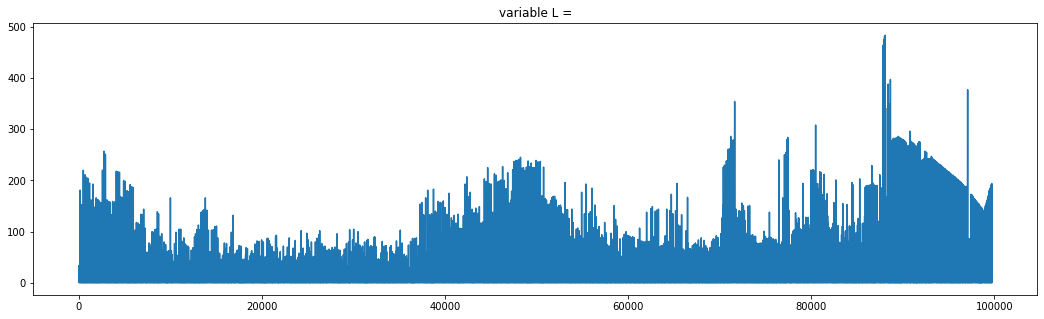

In [138]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(dataframe1.iloc[:,0])
plt.title("variable L =")

Text(0.5, 1.0, 'variable I =')

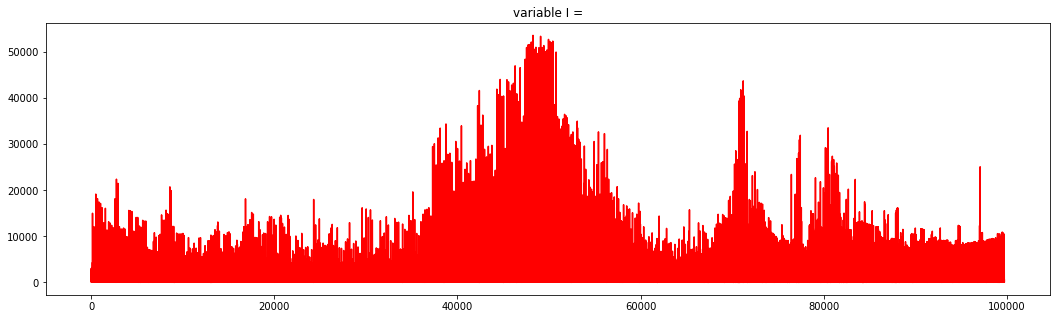

In [139]:
plt.plot(dataframe1.iloc[:,1], color = 'red')
plt.title("variable I =")

Text(0.5, 1.0, 'variable D =')

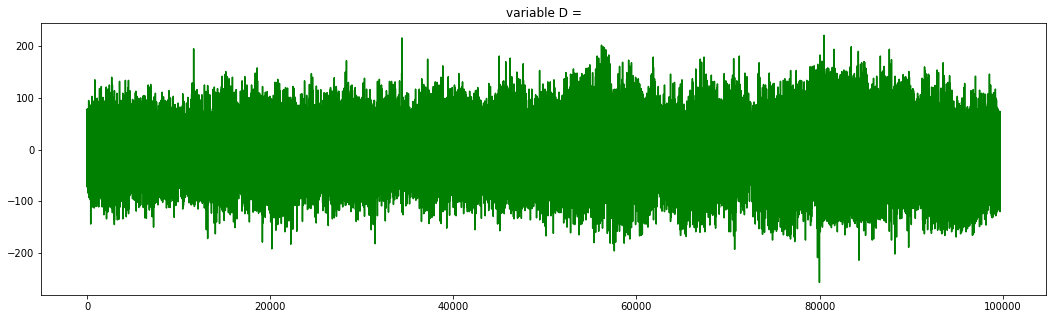

In [140]:
plt.plot(dataframe1.iloc[:,2], color = 'green')
plt.title("variable D =")

Text(0.5, 1.0, 'variable M =')

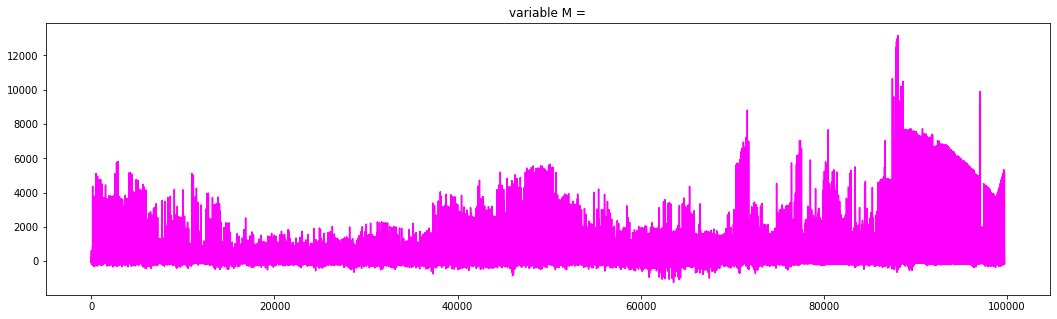

In [141]:
plt.plot(dataframe1.iloc[:,3], color = 'magenta')
plt.title("variable M =")

Text(0.5, 1.0, 'variable x0 =')

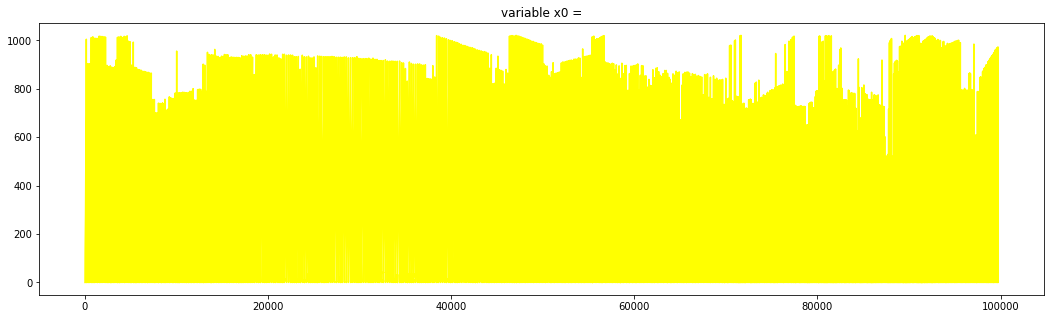

In [142]:
plt.plot(dataframe1.iloc[:,4], color = 'yellow')
plt.title("variable x0 =")